# Distribuciones Reales - Simulación

## Sin Deep_AR

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from scipy.stats import t
from scipy.linalg import svd, solve
from statsmodels.tsa.seasonal import seasonal_decompose
from bayes_opt import BayesianOptimization
from properscoring import crps_ensemble
from numba import jit
from itertools import product


# -------------------- Clase 1: Simulador de Series -------------------- #
class TimeSeriesSimulator:
    def __init__(self, phi, theta, noise_dist, sigma, n, burn_in):
        self.phi = phi
        self.theta = theta
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.n = n
        self.burn_in = burn_in

    def generate_noise(self):
        """Genera ruido según la distribución especificada."""
        if self.noise_dist == 'normal':
            return np.random.normal(0, self.sigma, self.n)
        elif self.noise_dist == 'uniform':
            return np.random.uniform(-np.sqrt(3)*self.sigma, np.sqrt(3)*self.sigma, self.n)
        elif self.noise_dist == 'exponential':
            return np.random.exponential(scale=self.sigma, size=self.n) - self.sigma
        elif self.noise_dist == 't':
            return self.sigma * t.rvs(df=3, size=self.n)
        else:
            raise ValueError("Distribución no soportada")

    def simulate_arma(self, noise):
        """Simula una serie ARMA usando ruido predefinido."""
        arma = ArmaProcess(ar=np.r_[1, -np.array(self.phi)], ma=np.r_[1, self.theta])

        def noise_generator(size):
            return np.random.choice(noise, size=size, replace=True)

        series = arma.generate_sample(nsample=self.n, scale=1, distrvs=noise_generator)
        return series[self.burn_in:], noise[self.burn_in:]  # Serie y ruido limpio


# -------------------- Clase 2: Modelo de Sieve Bootstrap -------------------- #
class SieveBootstrapModel:
    def __init__(self, bootstrap_reps):
        self.bootstrap_reps = bootstrap_reps

    def perform_bootstrap(self, series, residuals):
        """Realiza el re-muestreo (Bootstrap) usando residuales."""
        forecasts = []
        for _ in range(self.bootstrap_reps):
            resampled = np.random.choice(residuals, size=len(series), replace=True)
            simulated = series[-1] + np.cumsum(resampled)
            forecasts.append(simulated[:len(series)])
        return np.array(forecasts)

    def calculate_crps(self, real_values, ensemble_forecasts):
        """Calcula el CRPS entre la distribución real y la del Bootstrap."""
        ensemble_forecasts = np.transpose(ensemble_forecasts)  # (n_samples, bootstrap_reps)
        return np.mean(crps_ensemble(real_values, ensemble_forecasts, axis=1))


# -------------------- Clase 3: Modelo CPnewModel Avanzado -------------------- #
class CPnewModel:
    """Modelo avanzado para series temporales con optimización bayesiana y regularización adaptativa."""
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, alpha=0.1, poly_degree=2, 
                 seasonal_periods=[12], random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods
        self.mean_val = None
        self.std_val = None
        self.trends = []
        self.seasonalities = []
        self.random_state = random_state
        np.random.seed(self.random_state)

    def decompose_series(self, df):
        """Elimina tendencia y múltiples estacionalidades."""
        values = df['valor']
        residual = values.copy()

        self.trends = []
        self.seasonalities = []

        for period in self.seasonal_periods:
            result = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
            self.trends.append(result.trend)
            self.seasonalities.append(result.seasonal)
            residual -= result.trend.fillna(0) + result.seasonal.fillna(0)

        return residual.fillna(0)

    def recombine_components(self, predictions):
        """Agrega la tendencia y estacionalidades de nuevo a las predicciones."""
        trend_sum = sum(trend.iloc[-1] for trend in self.trends if trend is not None)
        seasonal_sum = sum(season.iloc[-1] for season in self.seasonalities if season is not None)
        return predictions + trend_sum + seasonal_sum

    @staticmethod
    @jit(nopython=True)
    def _create_lag_matrix(values, n_lags, degree=2):
        """Crea matriz de rezagos con términos polinomiales."""
        n = len(values) - n_lags
        X = np.ones((n, 1))  # Intercepto
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1)
            X = np.hstack((X, lagged))
            if degree > 1:
                for d in range(2, degree + 1):
                    X = np.hstack((X, lagged ** d))  # Términos polinomiales
        return X

    def prepare_data(self, df):
        """Prepara los datos normalizando y eliminando tendencias/estacionalidades."""
        detrended_values = self.decompose_series(df)
        detrended_values = detrended_values.replace([np.inf, -np.inf], np.nan).fillna(0)
        self.mean_val = np.mean(detrended_values)
        self.std_val = np.std(detrended_values)
        normalized_values = (detrended_values - self.mean_val) / (self.std_val + 1e-8)
        return normalized_values.to_numpy()

    def adaptive_regularization(self, X):
        """Calcula regularización adaptativa basada en la condición de la matriz."""
        _, s, _ = svd(X)
        condition_number = s[0] / (s[-1] + 1e-10)
        regularization = min(1.0, 1 / (condition_number + 1e-5))
        return regularization

    def calculate_C_values(self, X, y):
        """Calcula los valores C usando Ridge con regularización adaptativa."""
        adaptive_alpha = self.adaptive_regularization(X)
        ridge = Ridge(alpha=adaptive_alpha, fit_intercept=False)
        ridge.fit(X, y)
        y_pred = ridge.predict(X)
        residuals = y - y_pred
        XtX_inv = np.linalg.pinv(X.T @ X + adaptive_alpha * np.eye(X.shape[1]))
        C = y_pred + (X @ XtX_inv @ X.T @ residuals)
        return C

    def apply_weights(self, C):
        """Aplica pesos exponenciales."""
        weights = self.rho ** np.arange(len(C)-1, -1, -1)
        weights = weights / np.sum(weights)
        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)
        return np.repeat(C, repeats)

    def fit_predict(self, df):
        """Ajusta el modelo y retorna la distribución predictiva."""
        normalized_values = self.prepare_data(df)
        X = self._create_lag_matrix(normalized_values, self.n_lags, self.poly_degree)
        y = normalized_values[self.n_lags:]
        C = self.calculate_C_values(X, y)
        C_weighted = self.apply_weights(C)
        final_predictions = self.recombine_components(C_weighted)
        return final_predictions

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva."""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]


# -------------------- Clase 4: TimeDistributionModel -------------------- #
class TimeDistributionModel:
    """Modelo para generar distribuciones predictivas de series temporales"""

    def __init__(self, n_lags=5, rho=0.95, max_points=10000, random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.mean_val = None
        self.std_val = None
        self.trend = None
        self.seasonality = None
        self.random_state = random_state
        np.random.seed(self.random_state)

    def decompose_series(self, df, period=12):
        """Descompone la serie en tendencia, estacionalidad y error"""
        result = seasonal_decompose(df['valor'], period=period, model='additive', extrapolate_trend='freq')
        self.trend = result.trend.fillna(0)
        self.seasonality = result.seasonal.fillna(0)
        error = result.resid.fillna(0)  # Componente de error (residuo)
        return error

    def prepare_data(self, df):
        """Normaliza el componente de error"""
        error_component = self.decompose_series(df)
        self.mean_val = np.mean(error_component)
        self.std_val = np.std(error_component)
        normalized_error = (error_component - self.mean_val) / (self.std_val + 1e-8)
        
        # Asegurarse de que sea un array de NumPy
        if isinstance(normalized_error, pd.Series):
            normalized_error = normalized_error.to_numpy()
        
        return normalized_error

    def denormalize(self, values):
        """Desnormaliza el componente de error"""
        return values * self.std_val + self.mean_val

    @staticmethod
    @jit(nopython=True)
    def _create_lag_matrix(values, n_lags):
        """Crea matriz de rezagos"""
        n = len(values) - n_lags
        X = np.zeros((n, n_lags + 1))
        X[:, 0] = 1  # Intercepto

        for lag in range(n_lags):
            X[:, lag + 1] = values[lag:lag + n]

        return X

    @staticmethod
    @jit(nopython=True)
    def _fast_hat_matrix(X):
        """Calcula la matriz hat de forma eficiente"""
        XtX = X.T @ X
        XtX_inv = np.linalg.inv(XtX + 1e-8 * np.eye(X.shape[1]))  # Regularización
        return X @ XtX_inv @ X.T

    def calculate_C_values(self, X, y, x_test):
        """Calcula los valores C para la distribución predictiva"""
        n = len(y)
        X_bar = np.vstack((X, x_test))
        H_bar = self._fast_hat_matrix(X_bar)
        H = H_bar[:-1, :-1]
        h = H_bar[-1, :-1]

        I_minus_H_inv = solve(np.eye(n) - H, np.eye(n))
        y_minus_Hy = y - H @ y
        h_i_star = H - np.outer(np.ones(n), h)

        return y + (h_i_star @ I_minus_H_inv) @ y_minus_Hy

    def apply_weights(self, C):
        """Aplica pesos a los valores C"""
        n = len(C)
        weights = self.rho ** np.arange(n-1, -1, -1)
        weights = weights / np.sum(weights)  # Normalización de los pesos

        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)

        return np.repeat(C, repeats)

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva"""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

    def fit_predict(self, df):
        """Ajusta el modelo y devuelve la distribución predictiva"""
        normalized_error = self.prepare_data(df)
        
        # Convertir a NumPy si aún es una Series de pandas
        if isinstance(normalized_error, pd.Series):
            normalized_error = normalized_error.to_numpy()
        
        X = self._create_lag_matrix(normalized_error, self.n_lags)
        y = normalized_error[self.n_lags:]

        last_values = normalized_error[-self.n_lags:]
        x_test = np.concatenate(([1], last_values[::-1]))

        C = self.calculate_C_values(X, y, x_test)
        C_weighted = self.apply_weights(C)

        # Desnormalizar el componente de error
        C_denorm = self.denormalize(C_weighted)

        # Recombinar componentes: Error + Tendencia + Estacionalidad
        final_predictions = C_denorm + self.trend.iloc[-1] + self.seasonality.iloc[-1]

        return final_predictions

    def grid_search(self, df, lags_range=range(1, 13), rho_range=np.linspace(0.5, 0.99, 10)):
        """Búsqueda en malla para encontrar los mejores n_lags y rho usando CRPS"""
        best_crps = float('inf')
        best_params = (None, None)
        y_real = df['valor'].iloc[-1]  # Valor real para la evaluación del CRPS

        for n_lags, rho in product(lags_range, rho_range):
            self.n_lags = n_lags
            self.rho = rho
            try:
                predictions = self.fit_predict(df)
                crps = self.calculate_crps(predictions, y_real)

                if crps < best_crps:
                    best_crps = crps
                    best_params = (n_lags, rho)

            except Exception as e:
                continue  # Ignorar errores numéricos

        # Asignar los mejores parámetros encontrados
        self.n_lags, self.rho = best_params
        print(f"✅ Mejores parámetros encontrados: n_lags = {self.n_lags}, rho = {self.rho}, CRPS = {best_crps:.4f}")
        return best_params


# -------------------- Clase 5: PlotManager -------------------- #
class PlotManager:
    @staticmethod
    def plot_series(series):
        """Gráfica la serie temporal simulada."""
        plt.figure(figsize=(10, 4))
        plt.plot(series, label="Serie Simulada", color='blue')
        plt.title("Serie Temporal Simulada")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_all_distributions(real_noise, bootstrap_samples, cp_predictions, tdm_predictions):
        """Gráfica comparativa de distribuciones: Real, Bootstrap, CPnewModel y TimeDistributionModel."""
        bootstrap_flat = bootstrap_samples.flatten()

        plt.figure(figsize=(12, 6))
        
        # Distribución Real
        plt.hist(real_noise, bins=50, alpha=0.3, color='green', density=True, label='Distribución Real')
        plt.axvline(np.mean(real_noise), color='green', linestyle='--', label='Media Real')

        # Distribución SieveBootstrap
        plt.hist(bootstrap_flat, bins=50, alpha=0.3, color='orange', density=True, label='SieveBootstrap')
        plt.axvline(np.mean(bootstrap_flat), color='orange', linestyle='--', label='Media Bootstrap')

        # Distribución CPnewModel
        plt.hist(cp_predictions, bins=50, alpha=0.3, color='purple', density=True, label='CPnewModel')
        plt.axvline(np.mean(cp_predictions), color='purple', linestyle='--', label='Media CPnewModel')
        
        # Distribución TimeDistributionModel
        plt.hist(tdm_predictions, bins=50, alpha=0.3, color='blue', density=True, label='TimeDistributionModel')
        plt.axvline(np.mean(tdm_predictions), color='blue', linestyle='--', label='Media TDM')

        plt.title("Comparación de Distribuciones: Real vs Bootstrap vs CPnewModel vs TDM")
        plt.xlabel("Valores")
        plt.ylabel("Densidad")
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def show_crps_results(crps_bootstrap, crps_cp, crps_tdm):
        """Muestra los CRPS en forma de DataFrame usando display()."""
        df_results = pd.DataFrame({
            "Modelo": ["SieveBootstrap", "CPnewModel", "TimeDistributionModel"],
            "CRPS": [crps_bootstrap, crps_cp, crps_tdm]
        })
        df_results = df_results.sort_values(by="CRPS", ascending=True)
        display(df_results)


# -------------------- Clase 6: Pipeline Principal -------------------- #
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from statsmodels.tsa.arima_process import ArmaProcess


class TimeSeriesPipeline:
    def __init__(self, phi, theta, noise_dist, sigma, n, burn_in, bootstrap_reps):
        self.simulator = TimeSeriesSimulator(phi, theta, noise_dist, sigma, n, burn_in)
        self.bootstrap_model = SieveBootstrapModel(bootstrap_reps)
        self.cp_model = CPnewModel()
        self.tdm_model = TimeDistributionModel()
        self.deepar_model = DeepARModel()
        self.plotter = PlotManager()

    def run(self):
        """Ejecuta todo el flujo: simulación, bootstrap, CPnewModel, TimeDistributionModel, gráficos y CRPS."""
        # Simulación
        noise = self.simulator.generate_noise()
        series, clean_noise = self.simulator.simulate_arma(noise)
        self.plotter.plot_series(series)

        # Preparación de datos para modelos
        df = pd.DataFrame({'valor': series})

        # Calculo de la densidad real
        real_density = gaussian_kde(clean_noise)
        x_eval = np.linspace(np.min(clean_noise), np.max(clean_noise), 500)
        real_density_values = real_density(x_eval)

        # Modelo SieveBootstrap
        bootstrap_samples = self.bootstrap_model.perform_bootstrap(series, clean_noise)
        crps_bootstrap = self.calculate_crps_density(x_eval, real_density_values, bootstrap_samples)
        print(f"SieveBootstrap - Mejor Lag: {self.bootstrap_model.best_lag}")

        # Modelo CPnewModel
        best_params_cp = self.cp_model.optimize_hyperparameters(df)
        cp_predictions = self.cp_model.fit_predict(df)
        crps_cp = self.calculate_crps_density(x_eval, real_density_values, cp_predictions)
        print(f"CPnewModel - Mejores Hiperparámetros: {best_params_cp}")

        # Modelo TimeDistributionModel
        best_params_tdm = self.tdm_model.grid_search(df)
        tdm_predictions = self.tdm_model.fit_predict(df)
        crps_tdm = self.calculate_crps_density(x_eval, real_density_values, tdm_predictions)
        print(f"TimeDistributionModel - Mejores Hiperparámetros: {best_params_tdm}")

        # Modelo DeepAR
        best_params_deepar = self.deepar_model.optimize_hyperparameters(df)
        deepar_predictions = self.deepar_model.fit_predict(df)
        crps_deepar = self.calculate_crps_density(x_eval, real_density_values, deepar_predictions)
        print(f"DeepAR - Mejores Hiperparámetros: {best_params_deepar}")

        # Gráfico Comparativo
        self.plotter.plot_all_distributions(clean_noise, bootstrap_samples,
                                           cp_predictions, tdm_predictions, deepar_predictions)

        # Mostrar CRPS como DataFrame
        self.plotter.show_crps_results(crps_bootstrap, crps_cp, crps_tdm, crps_deepar)


    def calculate_crps_density(self, x_eval, real_density_values, predictions):
        """Calcula el CRPS comparando la densidad real con la densidad predicha."""
        # Calcular la densidad estimada a partir de las predicciones
        predicted_density = gaussian_kde(predictions)
        predicted_density_values = predicted_density(x_eval)

        # Normalizar ambas densidades (opcional, pero recomendado)
        real_density_values /= np.trapz(real_density_values, x_eval)
        predicted_density_values /= np.trapz(predicted_density_values, x_eval)

        # Calcular CRPS usando las densidades evaluadas
        crps_value = self.crps_integral(x_eval, real_density_values, predicted_density_values)
        return crps_value


    def crps_integral(self, x, pdf_true, pdf_pred):
        """Calcula el CRPS usando integración numérica."""
        cdf_true = np.cumsum(pdf_true) * (x[1] - x[0])
        cdf_pred = np.cumsum(pdf_pred) * (x[1] - x[0])
        return np.trapz((cdf_pred - cdf_true)**2, x)


=== Ejecutando escenario: Ruido normal ===


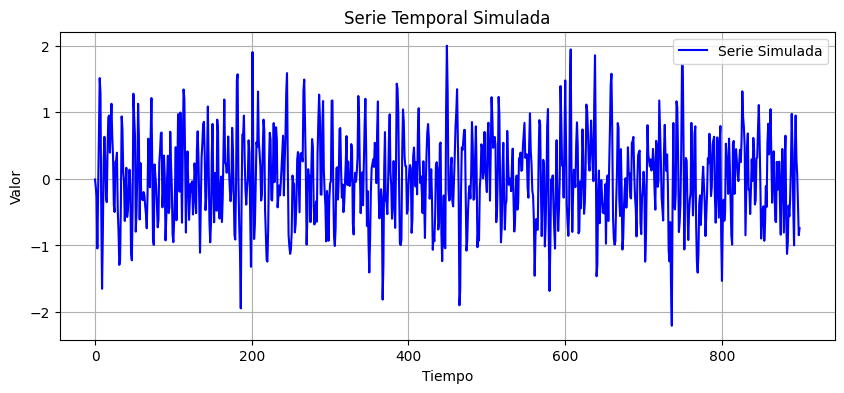

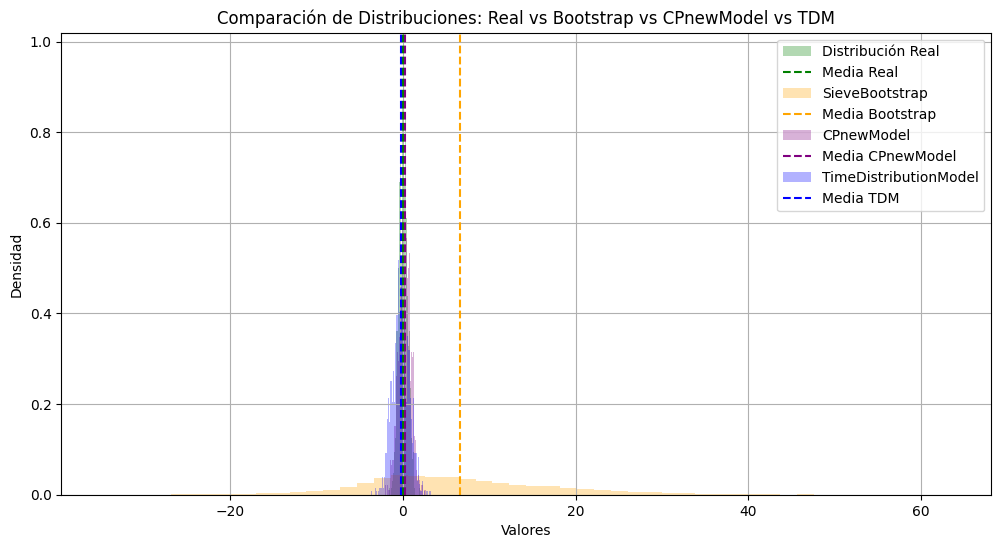

,Modelo,CRPS
2,TimeDistributionModel,0.322910
1,CPnewModel,0.614748
0,SieveBootstrap,4.213400



=== Ejecutando escenario: Ruido uniform ===


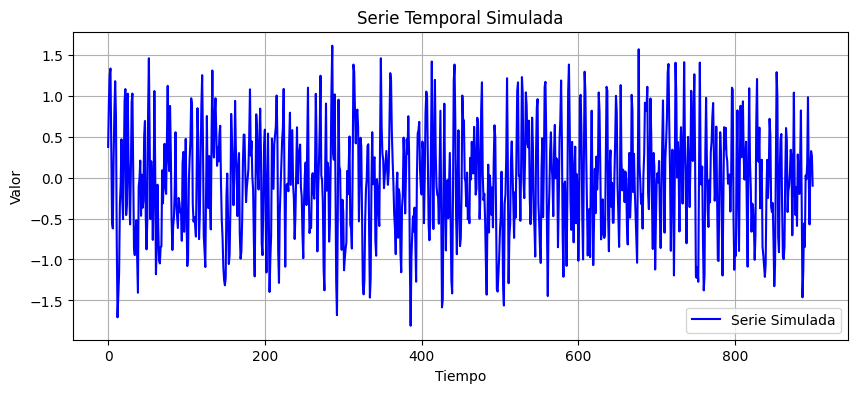

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess

class TimeSeriesScenarios:
    """Generador de escenarios diversos para probar modelos de series temporales"""
    
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(seed)
        
    def scenario_1_changing_noise_distribution(self):
        """Escenario 1: Cambios en la distribución del ruido"""
        scenarios = []
        distributions = ['normal', 'uniform', 't', 'exponential']
        
        for dist in distributions:
            scenario = {
                'name': f"Ruido {dist}",
                'phi': [0.5, -0.36],
                'theta': [0.4],
                'noise_dist': dist,
                'sigma': 0.5,
                'n': 1000,
                'burn_in': 100,
                'bootstrap_reps': 500
            }
            scenarios.append(scenario)
            
        return scenarios
    
    def scenario_2_structural_breaks(self):
        """Escenario 2: Series con cambios estructurales"""
        class StructuralBreakSimulator:
            def __init__(self, phi1, phi2, theta1, theta2, break_point, n, burn_in, noise_dist='normal', sigma=0.5):
                self.phi1 = phi1
                self.phi2 = phi2
                self.theta1 = theta1
                self.theta2 = theta2
                self.break_point = break_point
                self.n = n
                self.burn_in = burn_in
                self.noise_dist = noise_dist
                self.sigma = sigma
                
            def generate_noise(self):
                if self.noise_dist == 'normal':
                    return np.random.normal(0, self.sigma, self.n)
                else:
                    raise ValueError("Solo se soporta ruido normal para este escenario")
                
            def simulate_with_break(self):
                noise = self.generate_noise()
                
                # Primera parte de la serie
                arma1 = ArmaProcess(ar=np.r_[1, -np.array(self.phi1)], ma=np.r_[1, self.theta1])
                series1 = arma1.generate_sample(nsample=self.break_point)
                
                # Segunda parte de la serie
                arma2 = ArmaProcess(ar=np.r_[1, -np.array(self.phi2)], ma=np.r_[1, self.theta2])
                series2 = arma2.generate_sample(nsample=self.n-self.break_point)
                
                # Combinar ambas partes
                full_series = np.concatenate([series1, series2])
                
                return full_series[self.burn_in:], noise[self.burn_in:]
        
        scenarios = []
        
        # Escenario con cambio suave en AR
        scenario_1 = {
            'name': "Cambio suave en AR",
            'simulator': StructuralBreakSimulator(
                phi1=[0.3, -0.2],
                phi2=[0.7, -0.4],
                theta1=[0.2],
                theta2=[0.3],
                break_point=500,
                n=1000,
                burn_in=100
            ),
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Escenario con cambio brusco en MA
        scenario_2 = {
            'name': "Cambio brusco en MA",
            'simulator': StructuralBreakSimulator(
                phi1=[0.5, -0.3],
                phi2=[0.5, -0.3],
                theta1=[0.2],
                theta2=[0.8],
                break_point=500,
                n=1000,
                burn_in=100
            ),
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_3_seasonality_patterns(self):
        """Escenario 3: Diferentes patrones de estacionalidad"""
        
        def generate_seasonal_series(n, seasonal_periods, amplitudes, phi, theta, sigma=0.5):
            # Generar componente ARMA
            arma = ArmaProcess(ar=np.r_[1, -np.array(phi)], ma=np.r_[1, theta])
            arma_component = arma.generate_sample(nsample=n, scale=sigma)
            
            # Generar componentes estacionales
            t = np.arange(n)
            seasonal_component = np.zeros(n)
            for period, amplitude in zip(seasonal_periods, amplitudes):
                seasonal_component += amplitude * np.sin(2 * np.pi * t / period)
                
            # Combinar componentes
            series = arma_component + seasonal_component
            return series
        
        scenarios = []
        
        # Serie con estacionalidad simple (periodo=12, como datos mensuales)
        scenario_1 = {
            'name': "Estacionalidad simple (mensual)",
            'generate_func': lambda: generate_seasonal_series(
                n=1000, 
                seasonal_periods=[12], 
                amplitudes=[2.0], 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,  # Ya no necesitamos burn-in aquí
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con múltiples estacionalidades (diaria=7, anual=365)
        scenario_2 = {
            'name': "Múltiples estacionalidades (semanal+anual)",
            'generate_func': lambda: generate_seasonal_series(
                n=1000, 
                seasonal_periods=[7, 365], 
                amplitudes=[1.0, 3.0], 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_4_nonlinear_patterns(self):
        """Escenario 4: Patrones no lineales en series temporales"""
        
        def generate_nonlinear_series(n, nonlinearity_type, phi, theta, sigma=0.5):
            # Generar componente ARMA
            arma = ArmaProcess(ar=np.r_[1, -np.array(phi)], ma=np.r_[1, theta])
            arma_component = arma.generate_sample(nsample=n, scale=sigma)
            
            if nonlinearity_type == 'threshold':
                # Modelo de umbral: comportamiento diferente sobre/bajo un umbral
                threshold = 0
                series = np.zeros(n)
                for t in range(1, n):
                    if arma_component[t-1] > threshold:
                        series[t] = 0.7 * series[t-1] + arma_component[t]
                    else:
                        series[t] = -0.7 * series[t-1] + arma_component[t]
                        
            elif nonlinearity_type == 'exponential':
                # Transformación exponencial
                series = np.exp(arma_component / 3) - 1
                
            elif nonlinearity_type == 'squared':
                # Componente cuadrático
                series = arma_component + 0.3 * arma_component**2
                
            else:
                raise ValueError("Tipo de no linealidad no soportado")
                
            return series
        
        scenarios = []
        
        # Serie con no linealidad de umbral
        scenario_1 = {
            'name': "No linealidad de umbral",
            'generate_func': lambda: generate_nonlinear_series(
                n=1000, 
                nonlinearity_type='threshold', 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con no linealidad exponencial
        scenario_2 = {
            'name': "No linealidad exponencial",
            'generate_func': lambda: generate_nonlinear_series(
                n=1000, 
                nonlinearity_type='exponential', 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        # Serie con no linealidad cuadrática
        scenario_3 = {
            'name': "No linealidad cuadrática",
            'generate_func': lambda: generate_nonlinear_series(
                n=1000, 
                nonlinearity_type='squared', 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_3)
        
        return scenarios
    
    def scenario_5_volatility_clusters(self):
        """Escenario 5: Series con clusters de volatilidad (tipo GARCH)"""
        
        def generate_garch_like_series(n, phi, theta, a0=0.1, a1=0.2, b1=0.7, sigma=0.5):
            # Inicializar series
            series = np.zeros(n)
            volatility = np.zeros(n)
            errors = np.random.normal(0, 1, n)
            
            # Valores iniciales
            volatility[0] = sigma
            series[0] = sigma * errors[0]
            
            # Generar serie con volatilidad variable
            for t in range(1, n):
                # Actualizar volatilidad (proceso tipo GARCH)
                volatility[t] = np.sqrt(a0 + a1 * series[t-1]**2 + b1 * volatility[t-1]**2)
                
                # Generar valor de la serie
                series[t] = phi[0] * series[t-1] + theta[0] * errors[t-1] + volatility[t] * errors[t]
                
            return series
        
        scenarios = []
        
        # Serie con clusters de volatilidad moderados
        scenario_1 = {
            'name': "Volatilidad moderada",
            'generate_func': lambda: generate_garch_like_series(
                n=1000, 
                phi=[0.5], 
                theta=[0.4],
                a0=0.1,
                a1=0.1,
                b1=0.8
            ),
            'phi': [0.5],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con clusters de volatilidad intensos
        scenario_2 = {
            'name': "Volatilidad intensa",
            'generate_func': lambda: generate_garch_like_series(
                n=1000, 
                phi=[0.5], 
                theta=[0.4],
                a0=0.05,
                a1=0.3,
                b1=0.65
            ),
            'phi': [0.5],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_6_long_memory_processes(self):
        """Escenario 6: Procesos con memoria larga (tipo ARFIMA)"""
        
        def generate_long_memory_series(n, d, phi, theta, sigma=0.5):
            from statsmodels.tsa.arima_process import arma_generate_sample
            
            # Coeficientes de expansión para (1-L)^d
            k = 500  # número de coeficientes a usar en la aproximación
            j = np.arange(k)
            arfima_coef = np.array([1])
            for i in range(1, k):
                coef = arfima_coef[-1] * (i - 1 - d) / i
                arfima_coef = np.append(arfima_coef, coef)
                
            # Simular proceso ARMA
            arma_process = arma_generate_sample(ar=np.r_[1, -np.array(phi)], 
                                               ma=np.r_[1, np.array(theta)],
                                               nsample=n+k, scale=sigma)
            
            # Aplicar el filtro de memoria larga
            long_memory_series = np.zeros(n)
            for t in range(n):
                long_memory_series[t] = np.sum(arfima_coef * arma_process[t:t+k])
                
            return long_memory_series
        
        scenarios = []
        
        # Serie con memoria larga persistente (d > 0)
        scenario_1 = {
            'name': "Memoria larga persistente",
            'generate_func': lambda: generate_long_memory_series(
                n=1000, 
                d=0.3,  # 0 < d < 0.5 para proceso estacionario con memoria larga
                phi=[0.2], 
                theta=[0.1]
            ),
            'phi': [0.2],
            'theta': [0.1],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con memoria larga anti-persistente (d < 0)
        scenario_2 = {
            'name': "Memoria larga anti-persistente",
            'generate_func': lambda: generate_long_memory_series(
                n=1000, 
                d=-0.2,  # -0.5 < d < 0 para proceso anti-persistente
                phi=[0.2], 
                theta=[0.1]
            ),
            'phi': [0.2],
            'theta': [0.1],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_7_outliers_and_missing_data(self):
        """Escenario 7: Series con valores atípicos y datos faltantes"""
        
        def add_outliers_and_missing(series, outlier_prop=0.05, missing_prop=0.05, outlier_scale=5):
            modified_series = series.copy()
            n = len(series)
            
            # Agregar outliers
            outlier_indices = np.random.choice(n, size=int(n * outlier_prop), replace=False)
            outlier_signs = np.random.choice([-1, 1], size=len(outlier_indices))
            modified_series[outlier_indices] += outlier_signs * outlier_scale * np.std(series)
            
            # Agregar valores faltantes (NaN)
            missing_indices = np.random.choice(n, size=int(n * missing_prop), replace=False)
            modified_series[missing_indices] = np.nan
            
            return modified_series
        
        scenarios = []
        
        # Generar serie base ARMA
        def generate_base_series():
            arma = ArmaProcess(ar=np.r_[1, -0.5, 0.3], ma=np.r_[1, 0.4])
            return arma.generate_sample(nsample=1000, scale=0.5)
        
        # Serie con pocos outliers y datos faltantes
        scenario_1 = {
            'name': "Pocos outliers y datos faltantes",
            'generate_func': lambda: add_outliers_and_missing(
                generate_base_series(),
                outlier_prop=0.03,
                missing_prop=0.03
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con muchos outliers y datos faltantes
        scenario_2 = {
            'name': "Muchos outliers y datos faltantes",
            'generate_func': lambda: add_outliers_and_missing(
                generate_base_series(),
                outlier_prop=0.08,
                missing_prop=0.08,
                outlier_scale=7
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def get_all_scenarios(self):
        """Recopila todos los escenarios disponibles"""
        all_scenarios = []
        
        # Escenario 1: Cambios en la distribución del ruido
        all_scenarios.extend(self.scenario_1_changing_noise_distribution())
        
        # Escenario 2: Series con cambios estructurales
        all_scenarios.extend(self.scenario_2_structural_breaks())
        
        # Escenario 3: Diferentes patrones de estacionalidad
        all_scenarios.extend(self.scenario_3_seasonality_patterns())
        
        # Escenario 4: Patrones no lineales
        all_scenarios.extend(self.scenario_4_nonlinear_patterns())
        
        # Escenario 5: Clusters de volatilidad
        all_scenarios.extend(self.scenario_5_volatility_clusters())
        
        # Escenario 6: Procesos con memoria larga
        all_scenarios.extend(self.scenario_6_long_memory_processes())
        
        # Escenario 7: Outliers y datos faltantes
        all_scenarios.extend(self.scenario_7_outliers_and_missing_data())
        
        return all_scenarios
    
    import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate  # Instálala si no la tienes: pip install tabulate

# Asumiendo que ya tienes importadas todas las clases necesarias de tu código original

class EnhancedTimeSeriesPipeline:
    def __init__(self):
        self.results = []
        
    def run_scenario(self, scenario):
        """Ejecuta un escenario específico y evalúa los modelos"""
        print(f"\n=== Ejecutando escenario: {scenario['name']} ===")
        
        # Inicializar modelos
        bootstrap_model = SieveBootstrapModel(scenario['bootstrap_reps'])
        cp_model = CPnewModel()
        tdm_model = TimeDistributionModel()
        plotter = PlotManager()
        
        # Generar o simular la serie según el tipo de escenario
        if 'simulator' in scenario:
            # Escenario con simulador personalizado (ej: cambios estructurales)
            series, clean_noise = scenario['simulator'].simulate_with_break()
        elif 'generate_func' in scenario:
            # Escenario con función generadora personalizada
            series = scenario['generate_func']()
            
            # Si hay NaN en la serie (escenario con datos faltantes)
            if np.isnan(series).any():
                # Interpolación simple para datos faltantes
                series_df = pd.Series(series)
                series = series_df.interpolate(method='linear').fillna(
                    method='bfill').fillna(method='ffill').values
                
                # Para el ruido, usamos una aproximación simple
                clean_noise = np.diff(series, prepend=series[0])
            else:
                # Para otros escenarios, aproximamos el ruido como la diferencia
                clean_noise = np.diff(series, prepend=series[0])
        else:
            # Escenario estándar con TimeSeriesSimulator
            simulator = TimeSeriesSimulator(
                phi=scenario['phi'],
                theta=scenario['theta'],
                noise_dist=scenario['noise_dist'],
                sigma=scenario.get('sigma', 0.5),
                n=scenario['n'],
                burn_in=scenario['burn_in']
            )
            noise = simulator.generate_noise()
            series, clean_noise = simulator.simulate_arma(noise)
        
        # Graficar la serie
        plotter.plot_series(series)
        
        # Modelo SieveBootstrap
        bootstrap_samples = bootstrap_model.perform_bootstrap(series, clean_noise)
        crps_bootstrap = bootstrap_model.calculate_crps(clean_noise, bootstrap_samples)
        
        # Preparar DataFrame para los modelos
        df = pd.DataFrame({'valor': series})
        y_real = series[-1]
        
        # Modelo CPnewModel
        try:
            cp_predictions = cp_model.fit_predict(df)
            crps_cp = cp_model.calculate_crps(cp_predictions, y_real)
        except Exception as e:
            print(f"Error en CPnewModel: {str(e)}")
            cp_predictions = None
            crps_cp = float('inf')
        
        # Modelo TimeDistributionModel
        try:
            # Intentamos primero con grid_search
            try:
                tdm_model.grid_search(df)
            except:
                # Si falla, asignamos valores predeterminados
                tdm_model.n_lags = 5
                tdm_model.rho = 0.95
                
            tdm_predictions = tdm_model.fit_predict(df)
            crps_tdm = tdm_model.calculate_crps(tdm_predictions, y_real)
        except Exception as e:
            print(f"Error en TimeDistributionModel: {str(e)}")
            tdm_predictions = None
            crps_tdm = float('inf')
        
        # Si ambos modelos produjeron predicciones válidas, graficamos la comparación
        if cp_predictions is not None and tdm_predictions is not None:
            plotter.plot_all_distributions(clean_noise, bootstrap_samples, 
                                          cp_predictions, tdm_predictions)
        
        # Mostrar CRPS
        plotter.show_crps_results(crps_bootstrap, crps_cp, crps_tdm)
        
        # Guardar resultados
        result = {
            'scenario': scenario['name'],
            'crps_bootstrap': crps_bootstrap,
            'crps_cp': crps_cp,
            'crps_tdm': crps_tdm,
            'best_model': self._get_best_model_name(crps_bootstrap, crps_cp, crps_tdm)
        }
        self.results.append(result)
        
        return result
    
    def _get_best_model_name(self, crps_bootstrap, crps_cp, crps_tdm):
        """Determina cuál es el mejor modelo basado en CRPS"""
        crps_values = {
            'SieveBootstrap': crps_bootstrap,
            'CPnewModel': crps_cp,
            'TimeDistributionModel': crps_tdm
        }
        return min(crps_values, key=crps_values.get)
    
    def run_all_scenarios(self, scenarios):
        """Ejecuta todos los escenarios y genera un informe"""
        for scenario in scenarios:
            self.run_scenario(scenario)
        
        self._show_summary_report()
    
    def _show_summary_report(self):
        """Muestra un informe resumen de todos los escenarios ejecutados"""
        # Convertir resultados a DataFrame
        results_df = pd.DataFrame(self.results)
        
        # Contar cuántas veces ganó cada modelo
        model_wins = results_df['best_model'].value_counts()
        
        print("\n=== RESUMEN DE RESULTADOS ===")
        
        # Mostrar tabla de resultados
        headers = ["Escenario", "CRPS Bootstrap", "CRPS CPnewModel", "CRPS TimeDistModel", "Mejor Modelo"]
        table_data = []
        
        for _, row in results_df.iterrows():
            table_data.append([
                row['scenario'],
                f"{row['crps_bootstrap']:.4f}",
                f"{row['crps_cp']:.4f}" if row['crps_cp'] != float('inf') else "Error",
                f"{row['crps_tdm']:.4f}" if row['crps_tdm'] != float('inf') else "Error",
                row['best_model']
            ])
        
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        
        # Mostrar conteo de victorias
        print("\n=== VICTORIAS POR MODELO ===")
        for model, wins in model_wins.items():
            print(f"{model}: {wins} victoria(s)")
        
        # Calcular y mostrar CRPS promedio para cada modelo
        avg_bootstrap = results_df['crps_bootstrap'].mean()
        
        # Filtrar infinitos para calcular promedios
        cp_values = results_df['crps_cp'][results_df['crps_cp'] != float('inf')]
        tdm_values = results_df['crps_tdm'][results_df['crps_tdm'] != float('inf')]
        
        avg_cp = cp_values.mean() if len(cp_values) > 0 else "N/A"
        avg_tdm = tdm_values.mean() if len(tdm_values) > 0 else "N/A"
        
        print("\n=== CRPS PROMEDIO ===")
        print(f"SieveBootstrap: {avg_bootstrap:.4f}")
        print(f"CPnewModel: {avg_cp:.4f}" if isinstance(avg_cp, float) else f"CPnewModel: {avg_cp}")
        print(f"TimeDistributionModel: {avg_tdm:.4f}" if isinstance(avg_tdm, float) else f"TimeDistributionModel: {avg_tdm}")
        
        # Graficar comparación de modelos
        self._plot_model_comparison()
    
    def _plot_model_comparison(self):
        """Genera gráficos comparativos de los modelos en todos los escenarios"""
        results_df = pd.DataFrame(self.results)
        
        # Reemplazar infinitos con NaN para no afectar la visualización
        results_df = results_df.replace([float('inf'), -float('inf')], np.nan)
        
        plt.figure(figsize=(15, 8))
        
        # Gráfico de barras para CRPS por escenario
        scenarios = results_df['scenario'].values
        x = np.arange(len(scenarios))
        width = 0.25
        
        bootstrap_values = results_df['crps_bootstrap'].values
        cp_values = results_df['crps_cp'].values
        tdm_values = results_df['crps_tdm'].values
        
        plt.bar(x - width, bootstrap_values, width, label='SieveBootstrap', color='orange')
        plt.bar(x, cp_values, width, label='CPnewModel', color='purple')
        plt.bar(x + width, tdm_values, width, label='TimeDistributionModel', color='blue')
        
        plt.xlabel('Escenario')
        plt.ylabel('CRPS (menor es mejor)')
        plt.title('Comparación de CRPS por Escenario y Modelo')
        plt.xticks(x, scenarios, rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Gráfico de pastel para victorias
        plt.figure(figsize=(10, 6))
        model_wins = results_df['best_model'].value_counts()
        plt.pie(model_wins, labels=model_wins.index, autopct='%1.1f%%', 
                colors=['orange', 'purple', 'blue'])
        plt.title('Proporción de Victorias por Modelo')
        plt.show()


# Código para ejecutar todos los escenarios
if __name__ == "__main__":
    # Crear generador de escenarios
    scenario_generator = TimeSeriesScenarios()
    all_scenarios = scenario_generator.get_all_scenarios()
    
    # Crear y ejecutar el pipeline mejorado
    enhanced_pipeline = EnhancedTimeSeriesPipeline()
    enhanced_pipeline.run_all_scenarios(all_scenarios)

# Adicion DeepAr

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.linear_model import Ridge
from scipy.stats import t
from scipy.linalg import svd, solve
from statsmodels.tsa.seasonal import seasonal_decompose
from bayes_opt import BayesianOptimization
from properscoring import crps_ensemble
from numba import jit
from concurrent.futures import ThreadPoolExecutor
from itertools import product
from statsmodels.tsa.ar_model import AutoReg
from typing import Optional, Union, List, Tuple
from numpy.random import Generator
import warnings

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch no está disponible. DeepAR funcionará en modo limitado.")

warnings.filterwarnings("ignore")


## Clases adicionales

### Simulador de series

In [6]:
class TimeSeriesSimulator:
    def __init__(self, phi, theta, noise_dist, sigma, n, burn_in):
        self.phi = phi
        self.theta = theta
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.n = n
        self.burn_in = burn_in

    def generate_noise(self):
        """Genera ruido según la distribución especificada."""
        if self.noise_dist == 'normal':
            return np.random.normal(0, self.sigma, self.n)
        elif self.noise_dist == 'uniform':
            return np.random.uniform(-np.sqrt(3)*self.sigma, np.sqrt(3)*self.sigma, self.n)
        elif self.noise_dist == 'exponential':
            return np.random.exponential(scale=self.sigma, size=self.n) - self.sigma
        elif self.noise_dist == 't':
            return self.sigma * t.rvs(df=3, size=self.n)
        else:
            raise ValueError("Distribución no soportada")

    def simulate_arma(self, noise):
        """Simula una serie ARMA usando ruido predefinido."""
        arma = ArmaProcess(ar=np.r_[1, -np.array(self.phi)], ma=np.r_[1, self.theta])

        def noise_generator(size):
            return np.random.choice(noise, size=size, replace=True)

        series = arma.generate_sample(nsample=self.n, scale=1, distrvs=noise_generator)
        return series[self.burn_in:], noise[self.burn_in:]  # Serie y ruido limpio


### Plotting

In [7]:
class PlotManager:
    @staticmethod
    def plot_series(series):
        """Gráfica la serie temporal simulada."""
        plt.figure(figsize=(10, 4))
        plt.plot(series, label="Serie Simulada", color='blue')
        plt.title("Serie Temporal Simulada")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_all_distributions(real_noise, bootstrap_samples, cp_predictions, tdm_predictions, deepar_predictions=None):
        """Gráfica comparativa de distribuciones: Real, Bootstrap, CPnewModel, TimeDistributionModel y DeepAR."""
        bootstrap_flat = bootstrap_samples.flatten()

        plt.figure(figsize=(12, 6))

        # Calcular límites del eje x
        epsilon = 5  # Pequeño valor para agregar a los límites
        x_min = np.min(real_noise) - epsilon
        x_max = np.max(real_noise) + epsilon

        # Definir límites del eje y
        y_max = 2

        # Distribución Real - Más notoria (alpha=1, zorder=2)
        plt.hist(real_noise, bins=50, alpha=1, color='red', density=True, label='Distribución Real', zorder=2)
        plt.axvline(np.mean(real_noise), color='red', linestyle='--', linewidth=2, label='Media Real', zorder=2)

        # Distribución SieveBootstrap (alpha=0.3)
        plt.hist(bootstrap_flat, bins=50, alpha=0.3, color='orange', density=True, label='SieveBootstrap')
        plt.axvline(np.mean(bootstrap_flat), color='orange', linestyle='--', label='Media Bootstrap')

        # Distribución CPnewModel (alpha=0.3)
        plt.hist(cp_predictions, bins=50, alpha=0.3, color='purple', density=True, label='CPnewModel')
        plt.axvline(np.mean(cp_predictions), color='purple', linestyle='--', label='Media CPnewModel')

        # Distribución TimeDistributionModel (alpha=0.3)
        plt.hist(tdm_predictions, bins=50, alpha=0.3, color='blue', density=True, label='TimeDistributionModel')
        plt.axvline(np.mean(tdm_predictions), color='blue', linestyle='--', label='Media TimeDistributionModel')

        # Distribución DeepAR (alpha=0.3)
        if deepar_predictions is not None:
            plt.hist(deepar_predictions, bins=50, alpha=0.3, color='green', density=True, label='DeepAR')
            plt.axvline(np.mean(deepar_predictions), color='green', linestyle='--', label='Media DeepAR')



        # Establecer límites de los ejes
        plt.xlim(x_min, x_max)
        plt.ylim(0, y_max)

        plt.title("Comparación de Distribuciones Predictivas")
        plt.xlabel("Valor")
        plt.ylabel("Densidad")
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def show_crps_results(crps_bootstrap, crps_cp, crps_tdm, crps_deepar=None):
        """Muestra los CRPS en forma de DataFrame usando display()."""
        data = {
            "Modelo": ["SieveBootstrap", "CPnewModel", "TimeDistributionModel"],
            "CRPS": [crps_bootstrap, crps_cp, crps_tdm]
        }

        # Agregar DeepAR solo si está disponible
        if crps_deepar is not None:
            data["Modelo"].append("DeepAR")
            data["CRPS"].append(crps_deepar)

        df_results = pd.DataFrame(data)
        df_results = df_results.sort_values(by="CRPS", ascending=True)
        display(df_results)


### Pipeline

In [8]:
from typing import Dict, Tuple, Any
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import gaussian_kde

class TimeSeriesPipeline:
    """Pipeline completo para análisis de series temporales.
    
    Integra simulación, bootstrap, y múltiples modelos predictivos con evaluación
    de rendimiento y visualización de resultados.
    
    Attributes:
        simulator: Simulador de series temporales
        bootstrap_model: Modelo Sieve Bootstrap
        cp_model: Modelo CPnew
        tdm_model: Modelo de distribución temporal
        deepar_model: Modelo DeepAR
        plotter: Gestor de visualizaciones
    """
    
    def __init__(self, phi: float, theta: float, noise_dist: str, 
                 sigma: float, n: int, burn_in: int, bootstrap_reps: int):
        """Inicializa el pipeline con parámetros para todos los modelos.
        
        Args:
            phi: Parámetro AR
            theta: Parámetro MA
            noise_dist: Distribución del ruido ('normal', 'student_t', etc.)
            sigma: Desviación estándar del ruido
            n: Longitud de la serie temporal
            burn_in: Período de burn-in para simulación
            bootstrap_reps: Número de repeticiones bootstrap
        """
        self.simulator = TimeSeriesSimulator(phi, theta, noise_dist, sigma, n, burn_in)
        self.bootstrap_model = SieveBootstrapModel(bootstrap_reps=bootstrap_reps)
        self.cp_model = CPnewModel()
        self.tdm_model = TimeDistributionModel()
        self.deepar_model = DeepARModel()
        self.plotter = PlotManager()
        
        # Cache para resultados
        self._results_cache: Dict[str, Any] = {}
    
    def run(self) -> Dict[str, Any]:
        """Ejecuta el pipeline completo con procesamiento paralelo.
        
        Returns:
            Dict[str, Any]: Resultados completos incluyendo predicciones y métricas
        """
        # Simulación inicial
        noise = self.simulator.generate_noise()
        series, clean_noise = self.simulator.simulate_arma(noise)
        self.plotter.plot_series(series, title="Serie Temporal Original")
        
        # Preparación de datos
        df = pd.DataFrame({'valor': series})
        
        # Cálculo de la densidad real
        real_density = gaussian_kde(clean_noise)
        x_eval = np.linspace(np.min(clean_noise), np.max(clean_noise), 500)
        real_density_values = real_density(x_eval)
        
        # Ejecución paralela de modelos
        with ThreadPoolExecutor() as executor:
            futures = {
                'bootstrap': executor.submit(self._run_bootstrap_model, 
                                          df, x_eval, real_density_values),
                'cp': executor.submit(self._run_cp_model, 
                                    df, x_eval, real_density_values),
                'tdm': executor.submit(self._run_tdm_model, 
                                     df, x_eval, real_density_values),
                'deepar': executor.submit(self._run_deepar_model, 
                                        df, x_eval, real_density_values)
            }
            
            # Recolectar resultados
            results = {name: future.result() 
                      for name, future in futures.items()}
        
        # Almacenar resultados en caché
        self._results_cache = {
            'series': series,
            'clean_noise': clean_noise,
            'x_eval': x_eval,
            'real_density_values': real_density_values,
            **results
        }
        
        # Generar visualizaciones
        self._generate_visualizations(results)
        
        return self._results_cache
    
    def _run_bootstrap_model(self, df: pd.DataFrame, 
                            x_eval: np.ndarray, 
                            real_density_values: np.ndarray) -> Tuple[np.ndarray, float]:
        """Ejecuta el modelo bootstrap y calcula métricas.
        
        Args:
            df: DataFrame con la serie temporal
            x_eval: Puntos de evaluación para densidad
            real_density_values: Valores de densidad real
            
        Returns:
            Tuple[np.ndarray, float]: Predicciones y CRPS
        """
        bootstrap_samples = self.bootstrap_model.perform_bootstrap(df['valor'].values)
        crps = self.calculate_crps_density(x_eval, real_density_values, bootstrap_samples)
        
        return bootstrap_samples, crps
    
    def _run_cp_model(self, df: pd.DataFrame, 
                      x_eval: np.ndarray, 
                      real_density_values: np.ndarray) -> Tuple[np.ndarray, float, Dict]:
        """Ejecuta el modelo CP y calcula métricas.
        
        Args:
            df: DataFrame con la serie temporal
            x_eval: Puntos de evaluación para densidad
            real_density_values: Valores de densidad real
            
        Returns:
            Tuple[np.ndarray, float, Dict]: Predicciones, CRPS y mejores parámetros
        """
        best_params = self.cp_model.optimize_hyperparameters(df)
        predictions = self.cp_model.fit_predict(df)
        crps = self.calculate_crps_density(x_eval, real_density_values, predictions)
        
        return predictions, crps, best_params
    
    def _run_tdm_model(self, df: pd.DataFrame, 
                       x_eval: np.ndarray, 
                       real_density_values: np.ndarray) -> Tuple[np.ndarray, float, Dict]:
        """Ejecuta el modelo TDM y calcula métricas.
        
        Args:
            df: DataFrame con la serie temporal
            x_eval: Puntos de evaluación para densidad
            real_density_values: Valores de densidad real
            
        Returns:
            Tuple[np.ndarray, float, Dict]: Predicciones, CRPS y mejores parámetros
        """
        best_params = self.tdm_model.grid_search(df)
        predictions = self.tdm_model.fit_predict(df)
        crps = self.calculate_crps_density(x_eval, real_density_values, predictions)
        
        return predictions, crps, best_params
    
    def _run_deepar_model(self, df: pd.DataFrame, 
                         x_eval: np.ndarray, 
                         real_density_values: np.ndarray) -> Tuple[np.ndarray, float, Dict]:
        """Ejecuta el modelo DeepAR y calcula métricas.
        
        Args:
            df: DataFrame con la serie temporal
            x_eval: Puntos de evaluación para densidad
            real_density_values: Valores de densidad real
            
        Returns:
            Tuple[np.ndarray, float, Dict]: Predicciones, CRPS y mejores parámetros
        """
        best_params = self.deepar_model.optimize_hyperparameters(df)
        predictions = self.deepar_model.fit_predict(df)
        crps = self.calculate_crps_density(x_eval, real_density_values, predictions)
        
        return predictions, crps, best_params
    
    def calculate_crps_density(self, x_eval: np.ndarray, 
                             real_density_values: np.ndarray, 
                             predictions: np.ndarray) -> float:
        """Calcula el CRPS comparando densidades real y predicha.
        
        Args:
            x_eval: Puntos de evaluación para densidad
            real_density_values: Valores de densidad real
            predictions: Predicciones del modelo
            
        Returns:
            float: Valor CRPS
        """
        predicted_density = gaussian_kde(predictions)
        predicted_density_values = predicted_density(x_eval)
        
        # Normalizar densidades
        real_density_values /= np.trapz(real_density_values, x_eval)
        predicted_density_values /= np.trapz(predicted_density_values, x_eval)
        
        return self.crps_integral(x_eval, real_density_values, predicted_density_values)
    
    def crps_integral(self, x: np.ndarray, 
                      pdf_true: np.ndarray, 
                      pdf_pred: np.ndarray) -> float:
        """Calcula el CRPS usando integración numérica.
        
        Args:
            x: Puntos de evaluación
            pdf_true: Densidad verdadera
            pdf_pred: Densidad predicha
            
        Returns:
            float: Valor CRPS
        """
        dx = x[1] - x[0]
        cdf_true = np.cumsum(pdf_true) * dx
        cdf_pred = np.cumsum(pdf_pred) * dx
        
        return np.trapz((cdf_pred - cdf_true)**2, x)
    
    def _generate_visualizations(self, results: Dict[str, Any]) -> None:
        """Genera todas las visualizaciones de resultados.
        
        Args:
            results: Diccionario con resultados de todos los modelos
        """
        # Visualizar distribuciones
        self.plotter.plot_all_distributions(
            self._results_cache['clean_noise'],
            results['bootstrap'][0],  # predicciones bootstrap
            results['cp'][0],         # predicciones cp
            results['tdm'][0],        # predicciones tdm
            results['deepar'][0]      # predicciones deepar
        )
        
        # Mostrar tabla de CRPS
        crps_results = {
            'Bootstrap': results['bootstrap'][1],
            'CPnew': results['cp'][1],
            'TDM': results['tdm'][1],
            'DeepAR': results['deepar'][1]
        }
        self.plotter.show_crps_results(crps_results)
        
        # Mostrar mejores hiperparámetros
        print("\nMejores hiperparámetros encontrados:")
        print(f"CPnew: {results['cp'][2]}")
        print(f"TDM: {results['tdm'][2]}")
        print(f"DeepAR: {results['deepar'][2]}")
    
    def get_results(self) -> Dict[str, Any]:
        """Retorna los resultados cacheados del último run.
        
        Returns:
            Dict[str, Any]: Resultados completos del pipeline
            
        Raises:
            ValueError: Si no se ha ejecutado el pipeline
        """
        if not self._results_cache:
            raise ValueError("El pipeline no ha sido ejecutado todavía")
        return self._results_cache

## Clases de los modelos

### Bootstrapping

In [9]:

class SieveBootstrapModel:
    """Modelo Sieve Bootstrap optimizado para series temporales.
    
    Este modelo implementa el método Sieve Bootstrap para series temporales, permitiendo generar
    predicciones mediante remuestreo de residuales y simulación en paralelo.
    
    Attributes:
        bootstrap_reps (int): Número de repeticiones bootstrap
        random_state (int): Semilla para reproducibilidad
        n_lags (Optional[int]): Número de retardos para el modelo AutoReg
        model (Optional[AutoReg]): Modelo AutoReg ajustado
        mean_val (Optional[float]): Media de la serie original
        std_val (Optional[float]): Desviación estándar de la serie original
        cached_forecasts (Optional[np.ndarray]): Cache de las últimas predicciones
    """
    
    def __init__(self, bootstrap_reps: int, random_state: int = 42):
        """Inicializa el modelo Sieve Bootstrap.
        
        Args:
            bootstrap_reps (int): Número de repeticiones bootstrap
            random_state (int): Semilla para reproducibilidad
        
        Raises:
            ValueError: Si bootstrap_reps es menor que 1
        """
        if bootstrap_reps < 1:
            raise ValueError("bootstrap_reps debe ser mayor que 0")
            
        self.bootstrap_reps = bootstrap_reps
        self.random_state = random_state
        self.n_lags: Optional[int] = None
        self.model: Optional[AutoReg] = None
        self.mean_val: Optional[float] = None
        self.std_val: Optional[float] = None
        self._rng: Generator = np.random.default_rng(seed=random_state)
        self.cached_forecasts: Optional[np.ndarray] = None
    
    def normalize_data(self, series: np.ndarray) -> np.ndarray:
        """Normaliza los datos usando estandarización.
        
        Args:
            series (np.ndarray): Serie temporal a normalizar
            
        Returns:
            np.ndarray: Serie normalizada
            
        Raises:
            ValueError: Si la serie tiene desviación estándar 0
        """
        self.mean_val = np.mean(series)
        self.std_val = np.std(series)
        
        if self.std_val == 0:
            raise ValueError("La serie tiene desviación estándar 0")
            
        return (series - self.mean_val) / self.std_val
    
    def denormalize(self, values: np.ndarray) -> np.ndarray:
        """Desnormaliza los valores a la escala original.
        
        Args:
            values (np.ndarray): Valores normalizados
            
        Returns:
            np.ndarray: Valores en la escala original
            
        Raises:
            ValueError: Si mean_val o std_val no están definidos
        """
        if self.mean_val is None or self.std_val is None:
            raise ValueError("Debe llamar a normalize_data antes de denormalize")
            
        return values * self.std_val + self.mean_val
    
    def _single_bootstrap_iteration(self, normalized_series: np.ndarray, 
                                  residuals: Optional[np.ndarray]) -> np.ndarray:
        """Realiza una única iteración de bootstrap.
        
        Args:
            normalized_series (np.ndarray): Serie temporal normalizada
            residuals (Optional[np.ndarray]): Residuales pre-calculados (opcional)
            
        Returns:
            np.ndarray: Serie simulada para esta iteración
        """
        if self.model is None:
            self.model = AutoReg(normalized_series, lags=self.n_lags, old_names=False)
            fitted_model = self.model.fit()
        else:
            fitted_model = self.model.fit()
            
        base_prediction = fitted_model.forecast(steps=1)
        model_residuals = residuals if residuals is not None else fitted_model.resid
        
        resampled = self._rng.choice(model_residuals, size=len(normalized_series), replace=True)
        simulated = base_prediction + np.cumsum(resampled)
        return self.denormalize(simulated[:len(normalized_series)])
    
    def perform_bootstrap(self, series: np.ndarray, residuals: Optional[np.ndarray] = None) -> np.ndarray:
        """Realiza el bootstrap utilizando la metodología Sieve con procesamiento paralelo.
        
        Args:
            series (np.ndarray): Serie temporal original
            residuals (Optional[np.ndarray]): Residuales pre-calculados (opcional)
            
        Returns:
            np.ndarray: Array de predicciones bootstrap
            
        Raises:
            ValueError: Si la serie es demasiado corta para el número de lags
        """
        if len(series) < 3:
            raise ValueError("Serie demasiado corta para realizar bootstrap")
            
        normalized_series = self.normalize_data(series)
        
        if self.n_lags is None:
            self.grid_search_lags(normalized_series)
            
        if self.n_lags is None:
            self.n_lags = min(int(np.ceil(np.log(len(series)))), len(series) - 1)
            warnings.warn(f"No se pudo encontrar n_lags óptimo. Usando valor por defecto: {self.n_lags}")
        
        # Usar procesamiento paralelo para las simulaciones
        with ThreadPoolExecutor() as executor:
            futures = []
            for _ in range(self.bootstrap_reps):
                futures.append(executor.submit(self._single_bootstrap_iteration, 
                                            normalized_series, 
                                            residuals))
            
            forecasts = np.array([f.result() for f in futures])
        
        self.cached_forecasts = forecasts
        return forecasts
    
    def calculate_crps(self, real_values: np.ndarray, ensemble_forecasts: np.ndarray) -> float:
        """Calcula el CRPS entre valores reales y predicciones.
        
        Args:
            real_values (np.ndarray): Valores reales
            ensemble_forecasts (np.ndarray): Conjunto de predicciones bootstrap
            
        Returns:
            float: Valor CRPS promedio
            
        Raises:
            ValueError: Si las dimensiones no coinciden
        """
        if len(real_values) != ensemble_forecasts.shape[1]:
            raise ValueError("Dimensiones incompatibles entre valores reales y predicciones")
            
        ensemble_forecasts = np.transpose(ensemble_forecasts)
        return np.mean(crps_ensemble(real_values, ensemble_forecasts, axis=1))
    
    def grid_search_lags(self, series: np.ndarray, lags_range: range = range(1, 13)) -> Optional[int]:
        """Búsqueda en malla para encontrar el mejor n_lags usando CRPS.
        
        Args:
            series (np.ndarray): Serie temporal normalizada
            lags_range (range): Rango de valores n_lags a probar
            
        Returns:
            Optional[int]: Mejor valor de n_lags encontrado
            
        Note:
            Utiliza una versión reducida de bootstrap para optimizar rendimiento
        """
        results: List[Tuple[int, float]] = []
        min_bootstrap_reps = min(100, self.bootstrap_reps)
        
        for n_lags in lags_range:
            if n_lags >= len(series):
                continue
                
            try:
                temp_model = AutoReg(series, lags=n_lags, old_names=False)
                fitted = temp_model.fit()
                pred = fitted.forecast(steps=1)
                resids = fitted.resid
                
                # Realizar bootstrap reducido
                test_forecasts = np.zeros((min_bootstrap_reps, len(series)))
                for i in range(min_bootstrap_reps):
                    resampled = self._rng.choice(resids, size=len(series), replace=True)
                    simulated = pred + np.cumsum(resampled)
                    test_forecasts[i, :] = simulated[:len(series)]
                
                crps = self.calculate_crps(series, test_forecasts)
                results.append((n_lags, crps))
                
            except Exception:
                continue
        
        if not results:
            return None
            
        # Seleccionar el mejor n_lags
        self.n_lags, best_crps = min(results, key=lambda x: x[1])
        print(f"Bootstrapping: Mejor n_lags encontrado: {self.n_lags}, CRPS = {best_crps:.4f}")
        
        return self.n_lags
    
    def get_confidence_intervals(self, alpha: float = 0.05) -> Tuple[np.ndarray, np.ndarray]:
        """Calcula los intervalos de confianza de las predicciones bootstrap.
        
        Args:
            alpha (float): Nivel de significancia (por defecto 0.05 para IC del 95%)
            
        Returns:
            Tuple[np.ndarray, np.ndarray]: Límites inferior y superior del intervalo
            
        Raises:
            ValueError: Si no hay predicciones en caché
        """
        if self.cached_forecasts is None:
            raise ValueError("Debe ejecutar perform_bootstrap antes de calcular intervalos")
            
        lower = np.percentile(self.cached_forecasts, alpha * 100, axis=0)
        upper = np.percentile(self.cached_forecasts, (1 - alpha) * 100, axis=0)
        
        return lower, upper

### CPNewModel

In [10]:
class CPnewModel:
    """Modelo avanzado para series temporales con optimización bayesiana y regularización adaptativa."""
    
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, alpha=0.1, poly_degree=2, 
                 seasonal_periods=[12], random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods
        self.mean_val = None
        self.std_val = None
        self.trends = []
        self.seasonalities = []
        self.random_state = random_state
        np.random.seed(self.random_state)

    def optimize_hyperparameters(self, df):
        """
        Optimiza hiperparámetros usando Bayesian Optimization con estrategia robusta
        y múltiples intentos para garantizar convergencia.
        """
        def objective(n_lags, rho, poly_degree):
            # Convertir y validar parámetros
            try:
                n_lags_int = max(1, int(round(n_lags)))
                rho_bounded = min(0.999, max(0.5, float(rho)))
                poly_degree_int = max(1, int(round(poly_degree)))
                
                # Verificar que tenemos suficientes datos para los lags
                if len(df) <= n_lags_int * 2:
                    return -float('inf')
                
                # Configurar temporalmente los parámetros
                self.n_lags = n_lags_int
                self.rho = rho_bounded
                self.poly_degree = poly_degree_int
                
                # Realizar predicción con manejo de errores
                try:
                    df_copy = df.copy()
                    predictions = self.fit_predict(df_copy)
                    y_real = df_copy['valor'].iloc[-1]
                    
                    # Verificar validez de predicciones
                    if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                        return -float('inf')
                    
                    crps = self.calculate_crps(predictions, y_real)
                    
                    # Penalizar valores extremos de parámetros
                    penalty = 0
                    if n_lags_int > 8:  # Penalizar lags muy grandes
                        penalty += 0.1 * (n_lags_int - 8)
                    if rho_bounded > 0.98:  # Penalizar rho muy cercano a 1
                        penalty += 0.1 * (rho_bounded - 0.98) / 0.019
                    
                    return -(crps + penalty)  # Minimizar CRPS + penalty
                    
                except Exception as e:
                    print(f"Error en iteración: {str(e)}")
                    return -float('inf')
                    
            except Exception:
                return -float('inf')

        # Configurar el optimizador con límites más restrictivos
        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 8),        # Reducido el máximo de lags
                'rho': (0.7, 0.99),      # Rango más específico
                'poly_degree': (1, 3)     # Mantenido igual
            },
            random_state=self.random_state,
            verbose=0
        )
        
        # Estrategia de optimización en múltiples fases
        best_score = -float('inf')
        best_params = None
        
        # Fase 1: Exploración amplia
        optimizer.maximize(init_points=10, n_iter=15)
        
        if optimizer.max['target'] > best_score:
            best_score = optimizer.max['target']
            best_params = optimizer.max['params']
        
        # Fase 2: Búsqueda local alrededor del mejor punto
        if best_params:
            optimizer.set_bounds(
                new_bounds={
                    'n_lags': (max(1, best_params['n_lags'] - 1), 
                            min(8, best_params['n_lags'] + 1)),
                    'rho': (max(0.7, best_params['rho'] - 0.05),
                        min(0.99, best_params['rho'] + 0.05)),
                    'poly_degree': (max(1, best_params['poly_degree'] - 1),
                                min(3, best_params['poly_degree'] + 1))
                }
            )
            optimizer.maximize(init_points=5, n_iter=10)
        
        # Validar y aplicar los mejores parámetros encontrados
        if optimizer.max and optimizer.max['target'] > -float('inf'):
            final_params = optimizer.max['params']
            best_crps = -optimizer.max['target']
            
            # Actualizar parámetros con los mejores valores
            self.n_lags = max(1, int(round(final_params['n_lags'])))
            self.rho = min(0.999, max(0.5, final_params['rho']))
            self.poly_degree = max(1, int(round(final_params['poly_degree'])))
            
            print(f"✅ CPnewModel - Optimización exitosa:")
            print(f"  • Mejor lag: {self.n_lags}")
            print(f"  • Rho: {self.rho:.3f}")
            print(f"  • Grado polinomial: {self.poly_degree}")
            print(f"  • CRPS óptimo: {best_crps:.4f}")
        else:
            # Establecer valores por defecto seguros
            self.n_lags = 3
            self.rho = 0.85
            self.poly_degree = 2
            print("⚠️ La optimización no encontró valores óptimos. Usando valores seguros por defecto:")
            print(f"  • Lag: {self.n_lags}")
            print(f"  • Rho: {self.rho:.3f}")
            print(f"  • Grado polinomial: {self.poly_degree}")
        
        return self.n_lags, self.rho, self.poly_degree

    def decompose_series(self, df):
        """Elimina tendencia y múltiples estacionalidades."""
        values = df['valor']
        residual = values.copy()

        self.trends = []
        self.seasonalities = []

        for period in self.seasonal_periods:
            if len(residual) >= 2 * period:
                result = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
                self.trends.append(result.trend)
                self.seasonalities.append(result.seasonal)
                residual -= result.trend.fillna(0) + result.seasonal.fillna(0)

        return residual.fillna(0)

    def recombine_components(self, predictions):
        """Agrega la tendencia y estacionalidades de nuevo a las predicciones."""
        trend_sum = sum(trend.iloc[-1] for trend in self.trends if trend is not None and len(trend) > 0)
        seasonal_sum = sum(season.iloc[-1] for season in self.seasonalities if season is not None and len(season) > 0)
        return predictions + trend_sum + seasonal_sum

    @staticmethod
    @jit(nopython=True)
    def _create_lag_matrix(values, n_lags, degree=2):
        """Crea matriz de rezagos con términos polinomiales."""
        n = len(values) - n_lags
        X = np.ones((n, 1))  # Intercepto
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1)
            X = np.hstack((X, lagged))
            if degree > 1:
                for d in range(2, degree + 1):
                    X = np.hstack((X, lagged ** d))  # Términos polinomiales
        return X

    def prepare_data(self, df):
        """Prepara los datos normalizando y eliminando tendencias/estacionalidades."""
        detrended_values = self.decompose_series(df)
        detrended_values = detrended_values.replace([np.inf, -np.inf], np.nan).fillna(0)
        self.mean_val = np.mean(detrended_values)
        self.std_val = np.std(detrended_values)
        normalized_values = (detrended_values - self.mean_val) / (self.std_val + 1e-8)
        return normalized_values.to_numpy()

    def adaptive_regularization(self, X):
        """Calcula regularización adaptativa basada en la condición de la matriz."""
        _, s, _ = svd(X)
        condition_number = s[0] / (s[-1] + 1e-10)
        regularization = min(1.0, 1 / (condition_number + 1e-5))
        return regularization

    def calculate_C_values(self, X, y):
        """Calcula los valores C usando Ridge con regularización adaptativa."""
        adaptive_alpha = self.adaptive_regularization(X)
        ridge = Ridge(alpha=adaptive_alpha, fit_intercept=False)
        ridge.fit(X, y)
        y_pred = ridge.predict(X)
        residuals = y - y_pred
        XtX_inv = np.linalg.pinv(X.T @ X + adaptive_alpha * np.eye(X.shape[1]))
        C = y_pred + (X @ XtX_inv @ X.T @ residuals)
        return C

    def apply_weights(self, C):
        """Aplica pesos exponenciales."""
        weights = self.rho ** np.arange(len(C)-1, -1, -1)
        weights = weights / np.sum(weights)
        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)
        return np.repeat(C, repeats)

    def fit_predict(self, df):
        """Ajusta el modelo y retorna la distribución predictiva."""
        normalized_values = self.prepare_data(df)
        X = self._create_lag_matrix(normalized_values, self.n_lags, self.poly_degree)
        y = normalized_values[self.n_lags:]
        C = self.calculate_C_values(X, y)
        C_weighted = self.apply_weights(C)
        final_predictions = self.recombine_components(C_weighted)
        return final_predictions

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva."""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

### Time distribution Model

In [11]:
class TimeDistributionModel:
    """Modelo para generar distribuciones predictivas de series temporales"""

    def __init__(self, n_lags=5, rho=0.95, max_points=10000, random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.mean_val = None
        self.std_val = None
        self.trend = None
        self.seasonality = None
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.best_params = None

    def decompose_series(self, df, period=12):
        """Descompone la serie en tendencia, estacionalidad y error"""
        # Asegurarse de que el periodo sea válido para la longitud de la serie
        if len(df) >= 2 * period:
            result = seasonal_decompose(df['valor'], period=period, model='additive', extrapolate_trend='freq')
            self.trend = result.trend.fillna(0)
            self.seasonality = result.seasonal.fillna(0)
            error = result.resid.fillna(0)  # Componente de error (residuo)
        else:
            # Si la serie es muy corta, no hacer descomposición
            self.trend = pd.Series(0, index=df.index)
            self.seasonality = pd.Series(0, index=df.index)
            error = df['valor']
        return error

    def prepare_data(self, df):
        """Normaliza el componente de error"""
        error_component = self.decompose_series(df)
        self.mean_val = np.mean(error_component)
        self.std_val = np.std(error_component)
        normalized_error = (error_component - self.mean_val) / (self.std_val + 1e-8)
        
        # Asegurarse de que sea un array de NumPy
        if isinstance(normalized_error, pd.Series):
            normalized_error = normalized_error.to_numpy()
        
        return normalized_error

    def denormalize(self, values):
        """Desnormaliza el componente de error"""
        return values * self.std_val + self.mean_val

    @staticmethod
    @jit(nopython=True)
    def _create_lag_matrix(values, n_lags):
        """Crea matriz de rezagos"""
        n = len(values) - n_lags
        X = np.zeros((n, n_lags + 1))
        X[:, 0] = 1  # Intercepto

        for lag in range(n_lags):
            X[:, lag + 1] = values[lag:lag + n]

        return X

    @staticmethod
    @jit(nopython=True)
    def _fast_hat_matrix(X):
        """Calcula la matriz hat de forma eficiente"""
        XtX = X.T @ X
        XtX_inv = np.linalg.inv(XtX + 1e-8 * np.eye(X.shape[1]))  # Regularización
        return X @ XtX_inv @ X.T

    def calculate_C_values(self, X, y, x_test):
        """Calcula los valores C para la distribución predictiva"""
        n = len(y)
        X_bar = np.vstack((X, x_test))
        H_bar = self._fast_hat_matrix(X_bar)
        H = H_bar[:-1, :-1]
        h = H_bar[-1, :-1]

        I_minus_H_inv = solve(np.eye(n) - H, np.eye(n))
        y_minus_Hy = y - H @ y
        h_i_star = H - np.outer(np.ones(n), h)

        return y + (h_i_star @ I_minus_H_inv) @ y_minus_Hy

    def apply_weights(self, C):
        """Aplica pesos a los valores C"""
        n = len(C)
        weights = self.rho ** np.arange(n-1, -1, -1)
        weights = weights / np.sum(weights)  # Normalización de los pesos

        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)

        return np.repeat(C, repeats)

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva"""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

    def fit_predict(self, df):
        """Ajusta el modelo y devuelve la distribución predictiva"""
        normalized_error = self.prepare_data(df)
        
        # Convertir a NumPy si aún es una Series de pandas
        if isinstance(normalized_error, pd.Series):
            normalized_error = normalized_error.to_numpy()
        
        X = self._create_lag_matrix(normalized_error, self.n_lags)
        y = normalized_error[self.n_lags:]

        last_values = normalized_error[-self.n_lags:]
        x_test = np.concatenate(([1], last_values[::-1]))

        C = self.calculate_C_values(X, y, x_test)
        C_weighted = self.apply_weights(C)

        # Desnormalizar el componente de error
        C_denorm = self.denormalize(C_weighted)

        # Recombinar componentes: Error + Tendencia + Estacionalidad
        final_predictions = C_denorm + self.trend.iloc[-1] + self.seasonality.iloc[-1]

        return final_predictions

    def grid_search(self, df, lags_range=None, rho_range=None):
        """Búsqueda en malla para encontrar los mejores n_lags y rho usando CRPS"""
        if lags_range is None:
            lags_range = range(1, min(13, len(df) // 5))
        if rho_range is None:
            rho_range = np.linspace(0.5, 0.99, 10)
            
        best_crps = float('inf')
        best_params = (None, None)
        y_real = df['valor'].iloc[-1]  # Valor real para la evaluación del CRPS

        for n_lags, rho in product(lags_range, rho_range):
            self.n_lags = n_lags
            self.rho = rho
            try:
                predictions = self.fit_predict(df.copy())
                crps = self.calculate_crps(predictions, y_real)

                if crps < best_crps:
                    best_crps = crps
                    best_params = (n_lags, rho)

            except Exception as e:
                continue  # Ignorar errores numéricos

        # Asignar los mejores parámetros encontrados
        if best_params[0] is not None:
            self.n_lags, self.rho = best_params
            self.best_params = best_params
            print(f"✓ TimeDistributionModel - Mejores parámetros: n_lags = {self.n_lags}, rho = {self.rho:.3f}, CRPS = {best_crps:.4f}")
        else:
            # Si no se encontraron parámetros válidos, usar los predeterminados
            print("⚠ No se encontraron parámetros válidos, usando valores predeterminados")
            
        return best_params


### DeepAR

In [12]:
class DeepARModel:
    """Implementación simplificada de DeepAR para distribuciones predictivas"""

    def __init__(self, hidden_size=20, n_lags=5, num_layers=1, dropout=0.1,
                 lr=0.01, batch_size=32, epochs=100, num_samples=1000, random_state=42):
        self.hidden_size = hidden_size
        self.n_lags = n_lags
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.num_samples = num_samples
        self.model = None
        self.scaler_mean = None
        self.scaler_std = None
        self.random_state = random_state
        self.best_params = None

        # Fijar semillas para reproducibilidad
        np.random.seed(random_state)
        if TORCH_AVAILABLE:
            torch.manual_seed(random_state)

    class _DeepARNN(nn.Module):
        """Red neuronal para DeepAR"""

        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                                 batch_first=True, dropout=dropout)
            self.fc_mu = nn.Linear(hidden_size, 1)  # Para la media
            self.fc_sigma = nn.Linear(hidden_size, 1)  # Para la desviación estándar

        def forward(self, x):
            # x shape: (batch_size, seq_len, input_size)
            lstm_out, _ = self.lstm(x)
            # Tomamos solo la última salida para predecir
            last_out = lstm_out[:, -1, :]
            mu = self.fc_mu(last_out)
            # Aseguramos que sigma sea positivo
            sigma = torch.exp(self.fc_sigma(last_out))
            return mu, sigma

    def _create_sequences(self, series):
        """Crea secuencias de entrada para la LSTM"""
        X, y = [], []
        for i in range(len(series) - self.n_lags):
            X.append(series[i:i + self.n_lags])
            y.append(series[i + self.n_lags])
        return np.array(X), np.array(y)

    def _train_model(self, X_train, y_train):
        """Entrena el modelo DeepAR"""
        if not TORCH_AVAILABLE:
            print("PyTorch no disponible. Usando aproximación gaussiana simple.")
            return None

        # Convertir a tensores
        X_tensor = torch.FloatTensor(X_train.reshape(-1, self.n_lags, 1))
        y_tensor = torch.FloatTensor(y_train.reshape(-1, 1))

        # Crear modelo, función de pérdida y optimizador
        model = self._DeepARNN(1, self.hidden_size, self.num_layers, self.dropout)
        criterion = nn.GaussianNLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr)

        # Entrenamiento
        model.train()
        for epoch in range(self.epochs):
            # Mini-batch training
            permutation = torch.randperm(X_tensor.size(0))
            for i in range(0, X_tensor.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_tensor[indices], y_tensor[indices]

                # Forward pass
                mu, sigma = model(batch_x)
                loss = criterion(mu, batch_y, sigma)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {loss.item():.4f}')

        return model

    def optimize_hyperparameters(self, df):
        """Optimiza hiperparámetros usando Bayesian Optimization"""
        if not TORCH_AVAILABLE:
            print("PyTorch no disponible. No se puede optimizar DeepAR.")
            return None

        def objective(n_lags, hidden_size, num_layers, dropout, lr):
            self.n_lags = max(1, int(n_lags))
            self.hidden_size = max(5, int(hidden_size))
            self.num_layers = max(1, int(num_layers))
            self.dropout = min(0.5, max(0.0, dropout))
            self.lr = max(0.0001, lr)

            try:
                predictions = self.fit_predict(df.copy())
                y_real = df['valor'].iloc[-1]
                crps = self.calculate_crps(predictions, y_real)
                return -crps  # Negativo porque queremos minimizar
            except:
                return -float('inf')

        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 10),
                'hidden_size': (5, 30),
                'num_layers': (1, 3),
                'dropout': (0.0, 0.3),
                'lr': (0.001, 0.1)
            },
            random_state=self.random_state
        )

        optimizer.maximize(init_points=3, n_iter=7)

        # Actualizar con los mejores parámetros
        best_params = optimizer.max['params']
        self.n_lags = max(1, int(best_params['n_lags']))
        self.hidden_size = max(5, int(best_params['hidden_size']))
        self.num_layers = max(1, int(best_params['num_layers']))
        self.dropout = min(0.5, max(0.0, best_params['dropout']))
        self.lr = max(0.0001, best_params['lr'])

        self.best_params = best_params
        print(f"✓ DeepAR - Mejores parámetros: n_lags={self.n_lags}, hidden_size={self.hidden_size}, "
              f"num_layers={self.num_layers}, dropout={self.dropout:.3f}, lr={self.lr:.4f}")
        return best_params

    def fit_predict(self, df):
        """Ajusta el modelo y genera distribución predictiva"""
        # Preparación de datos
        series = df['valor'].values

        # Normalización
        self.scaler_mean = np.mean(series)
        self.scaler_std = np.std(series)
        normalized_series = (series - self.scaler_mean) / (self.scaler_std + 1e-8)

        # Crear secuencias
        X_train, y_train = self._create_sequences(normalized_series)

        try:
            if TORCH_AVAILABLE:
                # Entrenar modelo
                self.model = self._train_model(X_train, y_train)

                # Generar distribución predictiva
                last_sequence = normalized_series[-self.n_lags:].reshape(1, self.n_lags, 1)
                last_sequence_tensor = torch.FloatTensor(last_sequence)

                self.model.eval()
                with torch.no_grad():
                    mu, sigma = self.model(last_sequence_tensor)
                    mu = mu.item()
                    sigma = sigma.item()

                # Generar muestras
                samples = np.random.normal(mu, sigma, self.num_samples)

            else:
                # Aproximación simple si PyTorch no está disponible
                mu = np.mean(y_train)
                sigma = np.std(y_train)
                samples = np.random.normal(mu, sigma, self.num_samples)

            # Desnormalizar
            predictions = samples * self.scaler_std + self.scaler_mean
            return predictions

        except Exception as e:
            print(f"Error en DeepAR fit_predict: {e}")
            # En caso de error, retornar un array con valores NaN
            return np.full(self.num_samples, np.nan)

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva."""
        # Eliminar NaNs antes de calcular CRPS
        distribution = distribution[~np.isnan(distribution)]

        if len(distribution) == 0:
            return float('inf')  # Si no quedan valores válidos, retornar infinito

        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]



## Clases de casos


=== Ejecutando escenario: Ruido normal ===


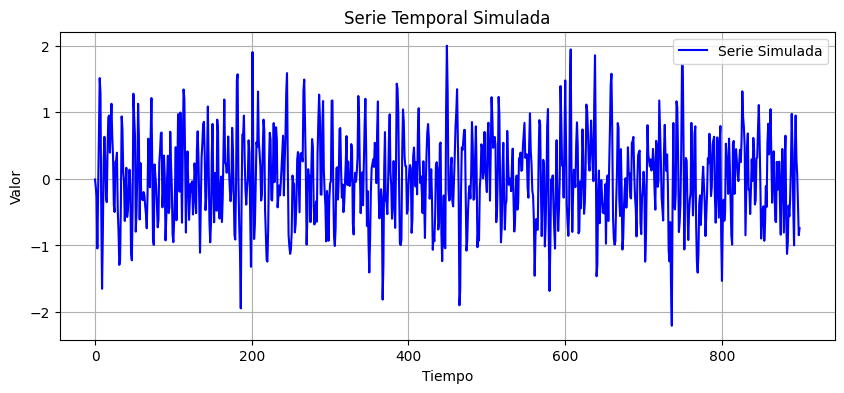

Bootstrapping: Mejor n_lags encontrado: 6, CRPS = 3.2898
✓ TimeDistributionModel - Mejores parámetros: n_lags = 6, rho = 0.718, CRPS = 0.2431
Epoch [20/100], Loss: 0.1782
Epoch [40/100], Loss: 0.0735
Epoch [60/100], Loss: 0.0149
Epoch [80/100], Loss: -0.2012
Epoch [100/100], Loss: -0.1816


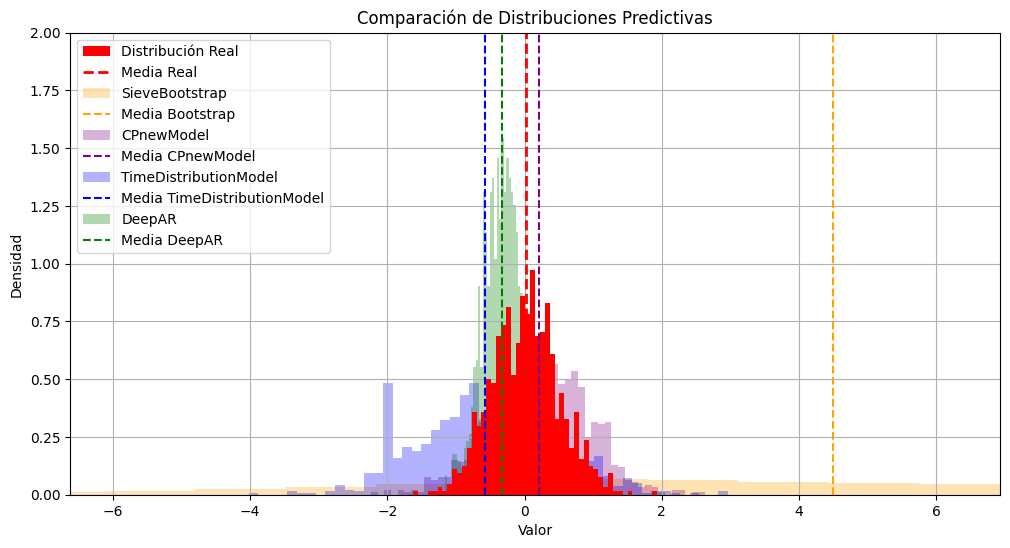

,Modelo,CRPS
2,TimeDistributionModel,0.243053
3,DeepAR,0.265837
1,CPnewModel,0.614748
0,SieveBootstrap,2.841452



=== Ejecutando escenario: Ruido uniform ===


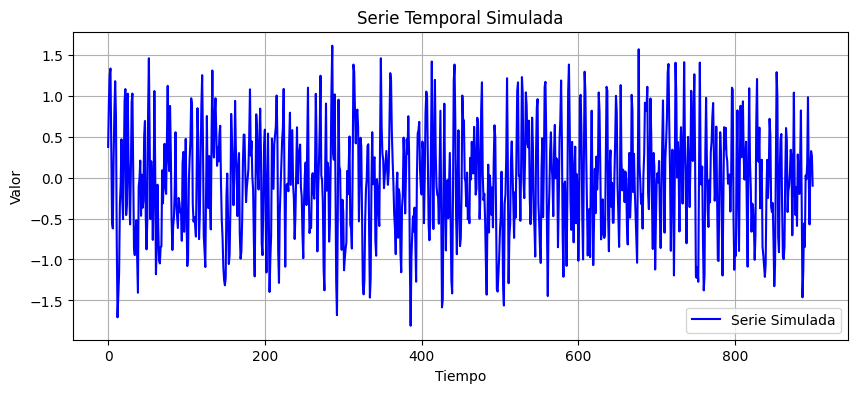

Bootstrapping: Mejor n_lags encontrado: 3, CRPS = 3.2123
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.500, CRPS = 0.1908
Epoch [20/100], Loss: 0.2036
Epoch [40/100], Loss: 0.1724
Epoch [60/100], Loss: 0.2760
Epoch [80/100], Loss: -0.5337
Epoch [100/100], Loss: -0.3824


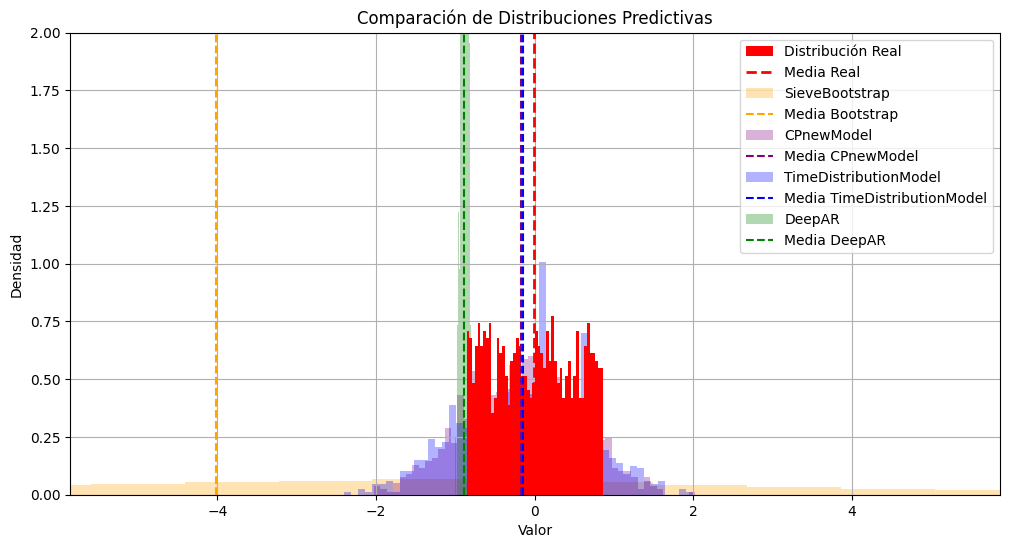

,Modelo,CRPS
1,CPnewModel,0.176415
2,TimeDistributionModel,0.190772
3,DeepAR,0.770690
0,SieveBootstrap,2.591060



=== Ejecutando escenario: Ruido t ===


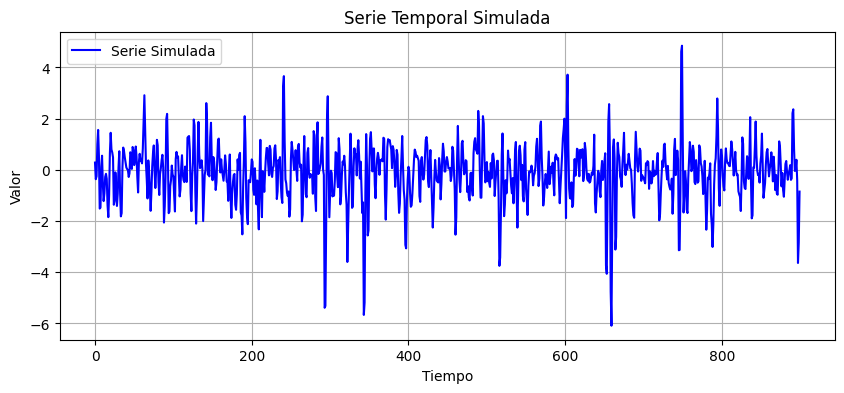

Bootstrapping: Mejor n_lags encontrado: 10, CRPS = 2.7989
✓ TimeDistributionModel - Mejores parámetros: n_lags = 7, rho = 0.990, CRPS = 0.3345
Epoch [20/100], Loss: -0.0372
Epoch [40/100], Loss: -0.1349
Epoch [60/100], Loss: -0.2706
Epoch [80/100], Loss: 0.0538
Epoch [100/100], Loss: -0.0990


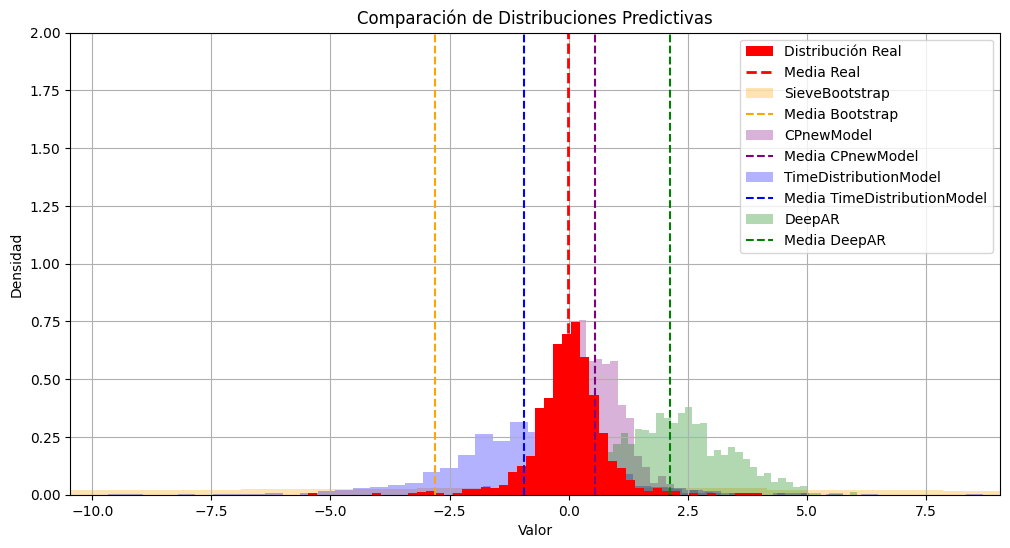

,Modelo,CRPS
2,TimeDistributionModel,0.334462
1,CPnewModel,1.054284
3,DeepAR,2.283172
0,SieveBootstrap,4.265303



=== Ejecutando escenario: Ruido exponential ===


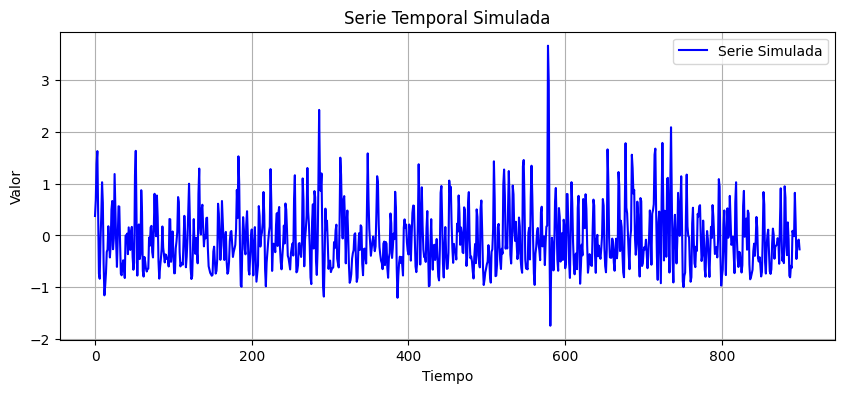

Bootstrapping: Mejor n_lags encontrado: 11, CRPS = 2.9513
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.554, CRPS = 0.1532
Epoch [20/100], Loss: 0.0199
Epoch [40/100], Loss: -0.0177
Epoch [60/100], Loss: 0.0200
Epoch [80/100], Loss: -0.0339
Epoch [100/100], Loss: -0.2574


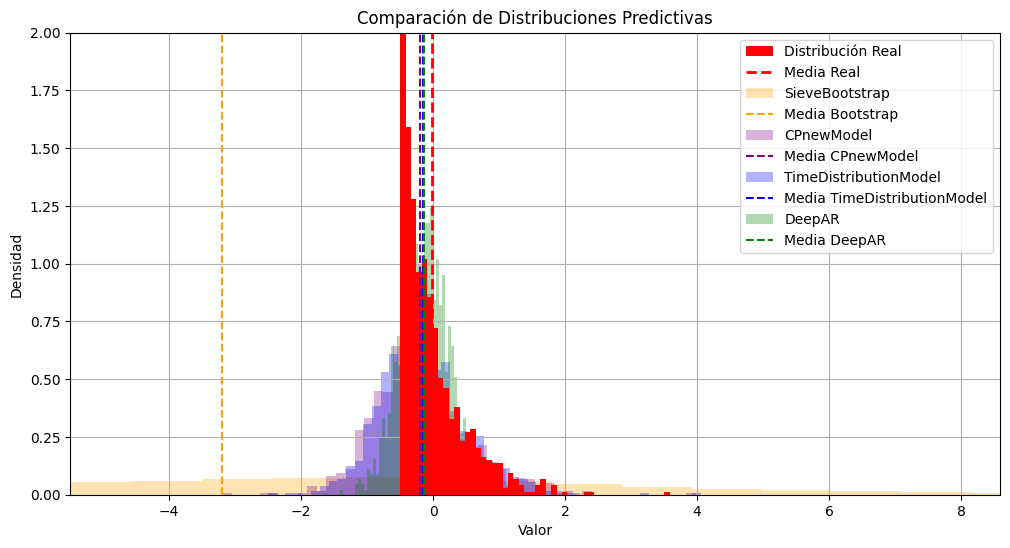

,Modelo,CRPS
3,DeepAR,0.103796
1,CPnewModel,0.146662
2,TimeDistributionModel,0.153176
0,SieveBootstrap,2.116829



=== Ejecutando escenario: Cambio suave en AR ===


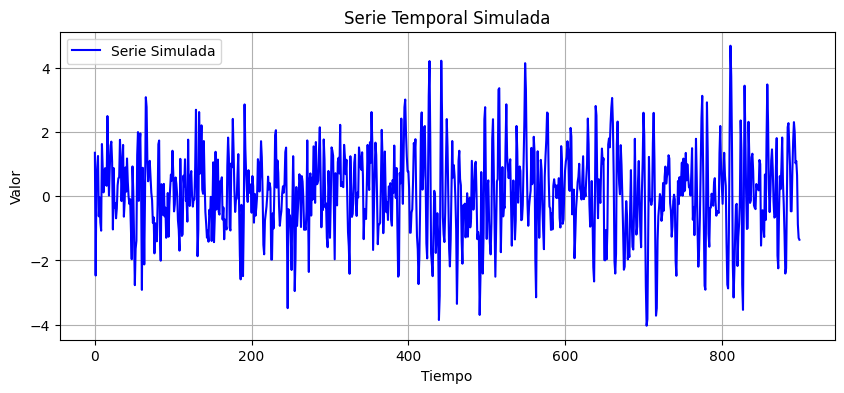

Bootstrapping: Mejor n_lags encontrado: 5, CRPS = 3.4569
✓ TimeDistributionModel - Mejores parámetros: n_lags = 7, rho = 0.663, CRPS = 0.5657
Epoch [20/100], Loss: 0.2163
Epoch [40/100], Loss: 0.2612
Epoch [60/100], Loss: -0.0873
Epoch [80/100], Loss: -0.1658
Epoch [100/100], Loss: -0.5581


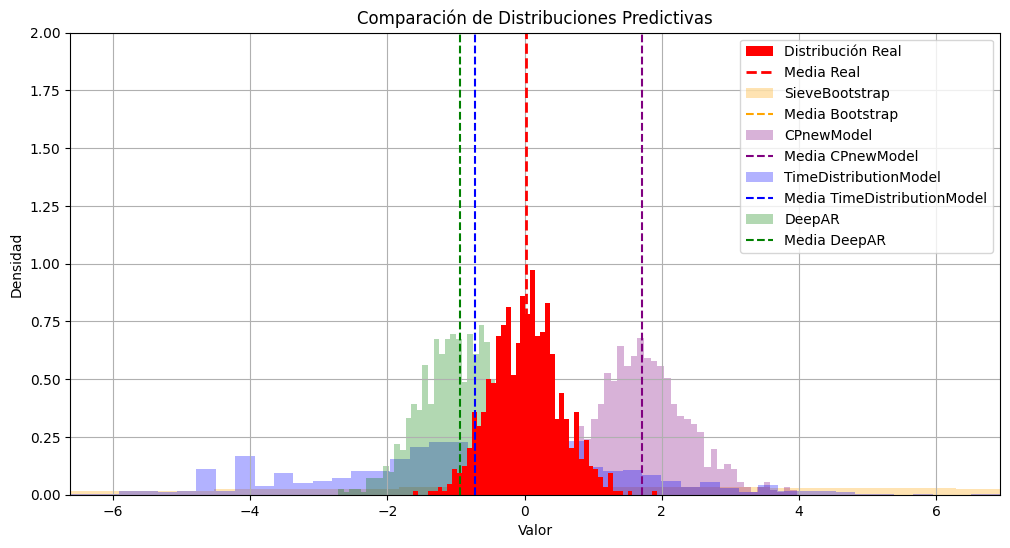

,Modelo,CRPS
3,DeepAR,0.251098
2,TimeDistributionModel,0.565667
1,CPnewModel,2.688619
0,SieveBootstrap,5.766166



=== Ejecutando escenario: Cambio brusco en MA ===


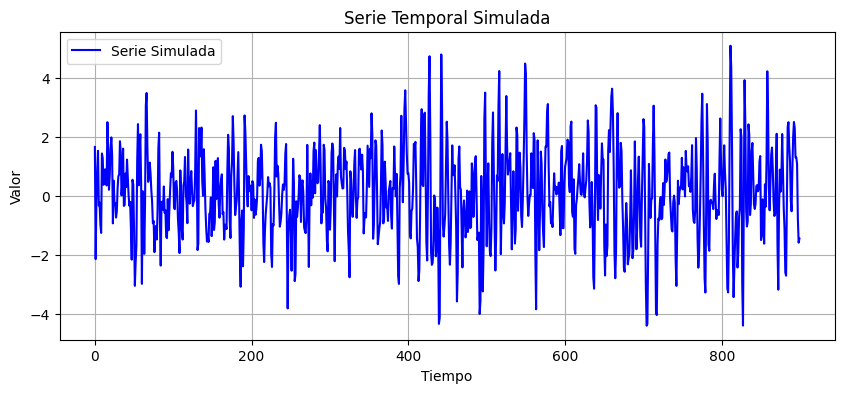

Bootstrapping: Mejor n_lags encontrado: 5, CRPS = 3.1284
✓ TimeDistributionModel - Mejores parámetros: n_lags = 7, rho = 0.663, CRPS = 0.6671
Epoch [20/100], Loss: 0.0806
Epoch [40/100], Loss: 0.0937
Epoch [60/100], Loss: -0.2354
Epoch [80/100], Loss: -0.3404
Epoch [100/100], Loss: -0.2335


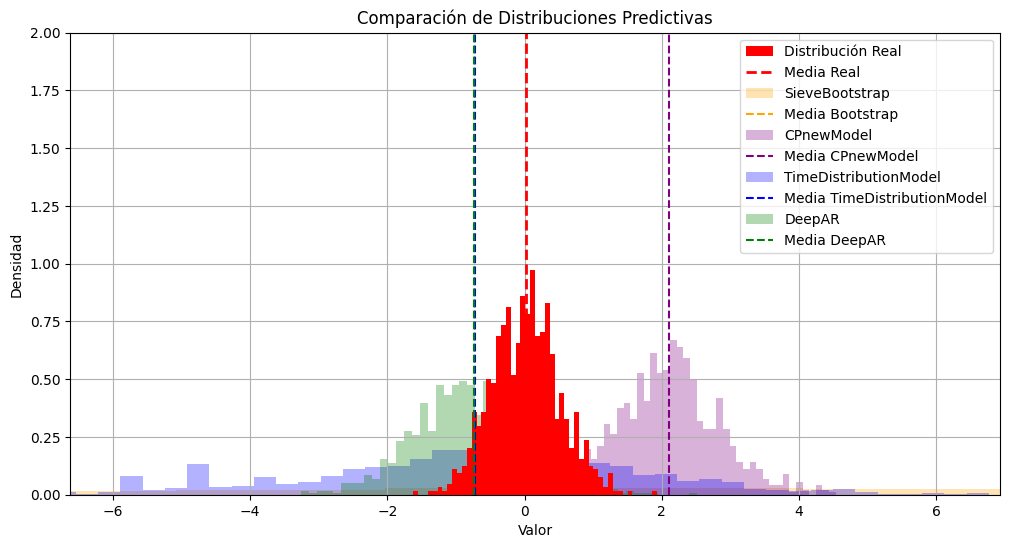

,Modelo,CRPS
3,DeepAR,0.410003
2,TimeDistributionModel,0.667145
1,CPnewModel,3.125913
0,SieveBootstrap,6.507869



=== Ejecutando escenario: Estacionalidad simple (mensual) ===


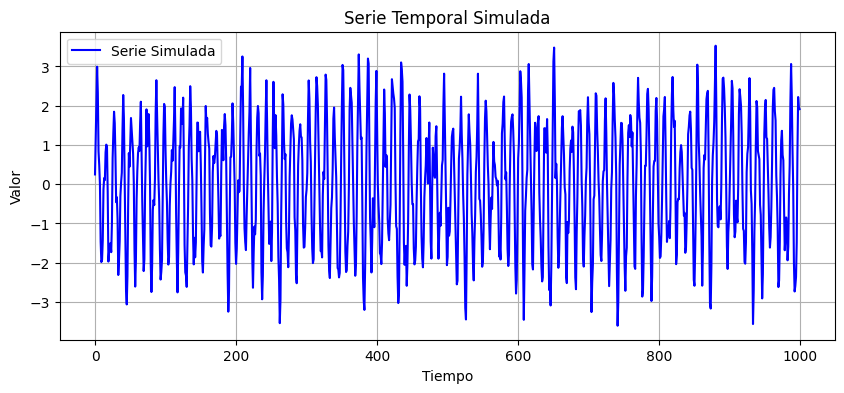

Bootstrapping: Mejor n_lags encontrado: 9, CRPS = 1.7559
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.500, CRPS = 0.1844
Epoch [20/100], Loss: -0.4982
Epoch [40/100], Loss: -0.7108
Epoch [60/100], Loss: -0.6420
Epoch [80/100], Loss: -0.5875
Epoch [100/100], Loss: -0.0916


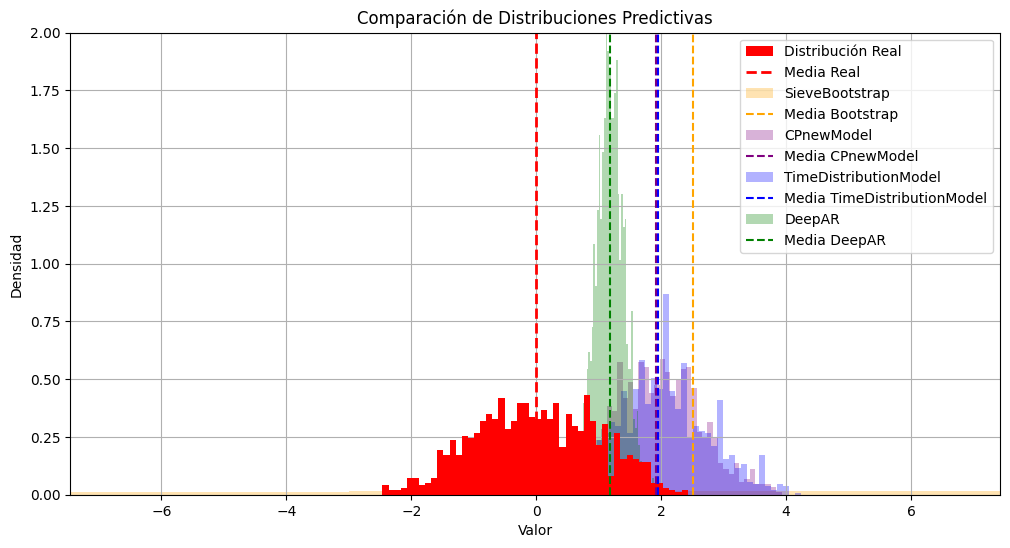

,Modelo,CRPS
1,CPnewModel,0.172636
2,TimeDistributionModel,0.184448
3,DeepAR,0.607480
0,SieveBootstrap,7.710408



=== Ejecutando escenario: Múltiples estacionalidades (semanal+anual) ===


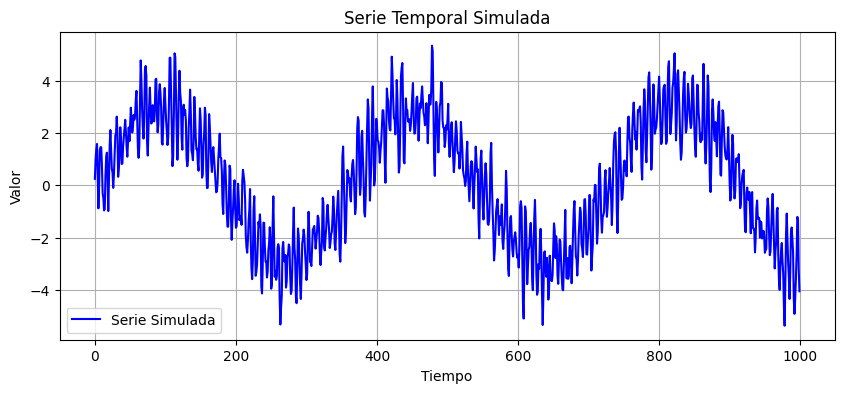

Bootstrapping: Mejor n_lags encontrado: 6, CRPS = 1.4563
✓ TimeDistributionModel - Mejores parámetros: n_lags = 2, rho = 0.990, CRPS = 0.4931
Epoch [20/100], Loss: -1.0829
Epoch [40/100], Loss: -1.0260
Epoch [60/100], Loss: -0.0631
Epoch [80/100], Loss: -0.2950
Epoch [100/100], Loss: 0.6148


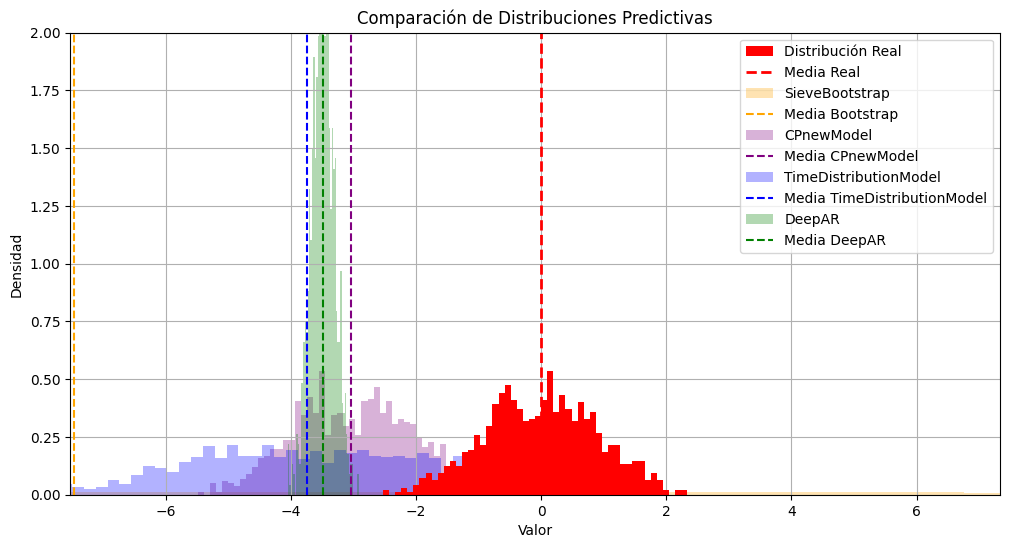

,Modelo,CRPS
3,DeepAR,0.455837
2,TimeDistributionModel,0.493115
1,CPnewModel,0.611112
0,SieveBootstrap,11.193031



=== Ejecutando escenario: No linealidad de umbral ===


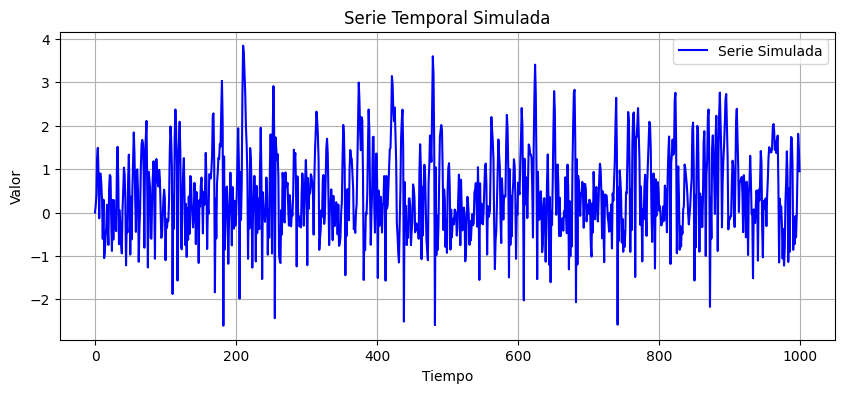

Bootstrapping: Mejor n_lags encontrado: 11, CRPS = 4.1182
✓ TimeDistributionModel - Mejores parámetros: n_lags = 6, rho = 0.990, CRPS = 0.2575
Epoch [20/100], Loss: -0.4489
Epoch [40/100], Loss: -0.1079
Epoch [60/100], Loss: -0.3014
Epoch [80/100], Loss: -0.6261
Epoch [100/100], Loss: -0.6686


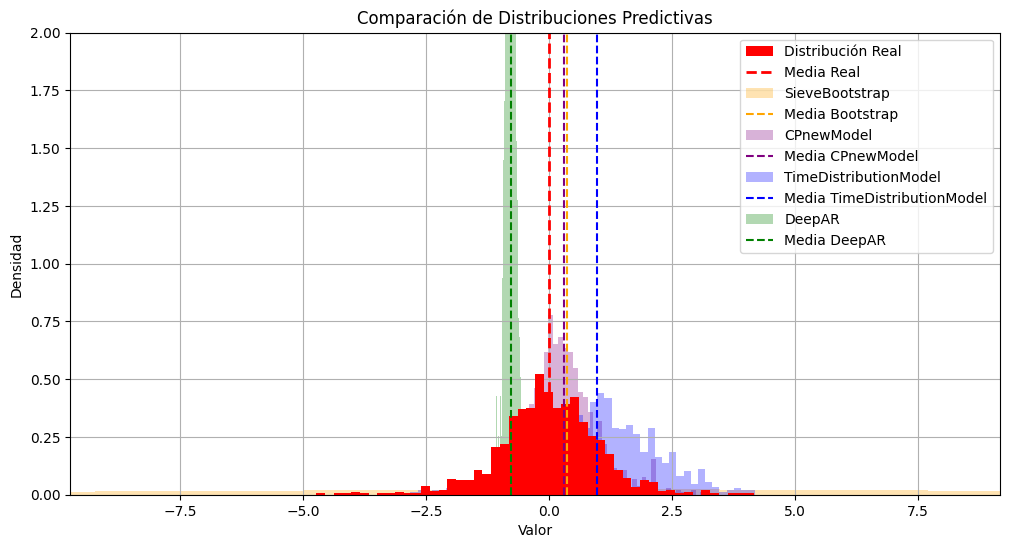

,Modelo,CRPS
2,TimeDistributionModel,0.257489
1,CPnewModel,0.422637
3,DeepAR,1.677916
0,SieveBootstrap,5.107983



=== Ejecutando escenario: No linealidad exponencial ===


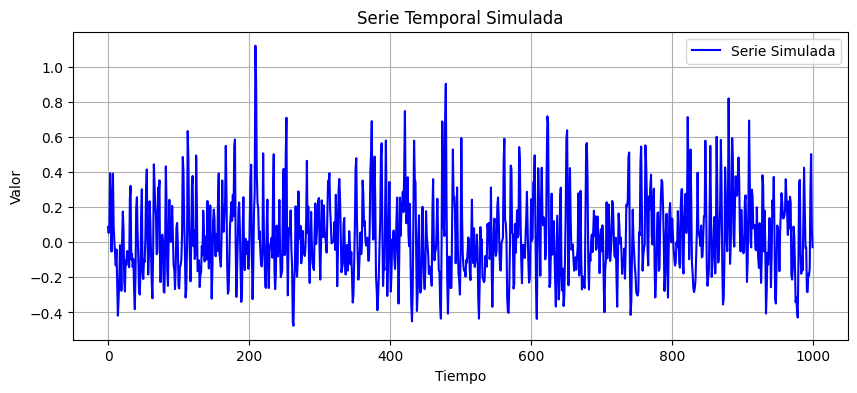

Bootstrapping: Mejor n_lags encontrado: 2, CRPS = 3.5755
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.500, CRPS = 0.0624
Epoch [20/100], Loss: -0.1079
Epoch [40/100], Loss: -0.2327
Epoch [60/100], Loss: 0.0830
Epoch [80/100], Loss: -0.1671
Epoch [100/100], Loss: -0.1541


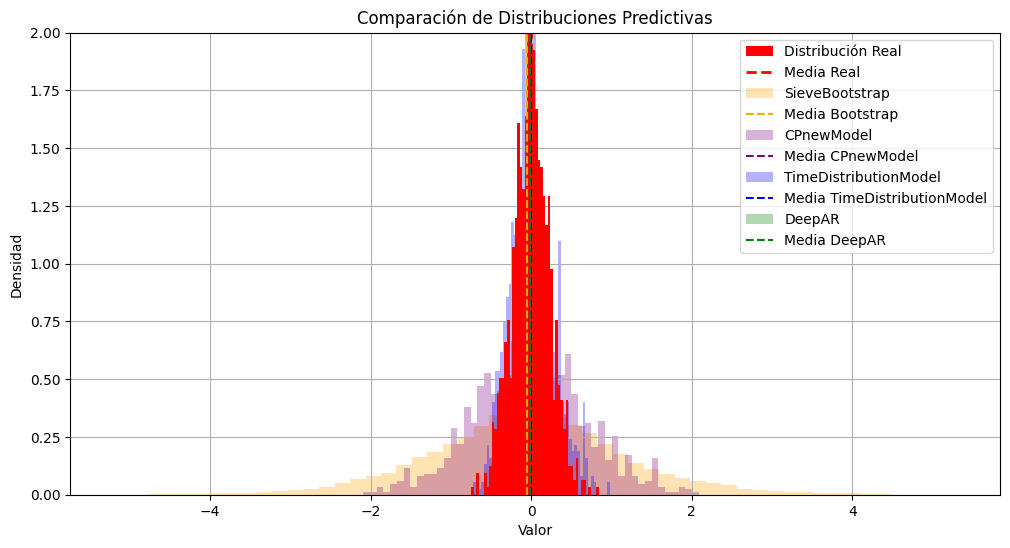

,Modelo,CRPS
3,DeepAR,0.006013
2,TimeDistributionModel,0.062425
1,CPnewModel,0.169626
0,SieveBootstrap,0.296865



=== Ejecutando escenario: No linealidad cuadrática ===


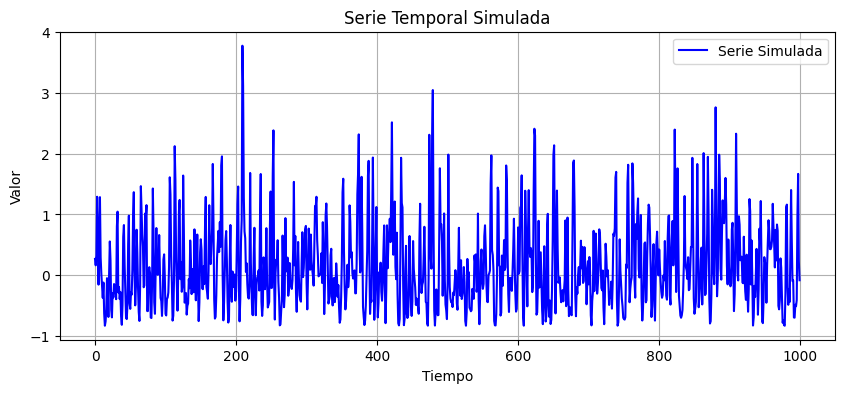

Bootstrapping: Mejor n_lags encontrado: 8, CRPS = 3.6768
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.990, CRPS = 0.1829
Epoch [20/100], Loss: -0.1589
Epoch [40/100], Loss: -0.5970
Epoch [60/100], Loss: 0.8232
Epoch [80/100], Loss: -0.4155
Epoch [100/100], Loss: -0.6028


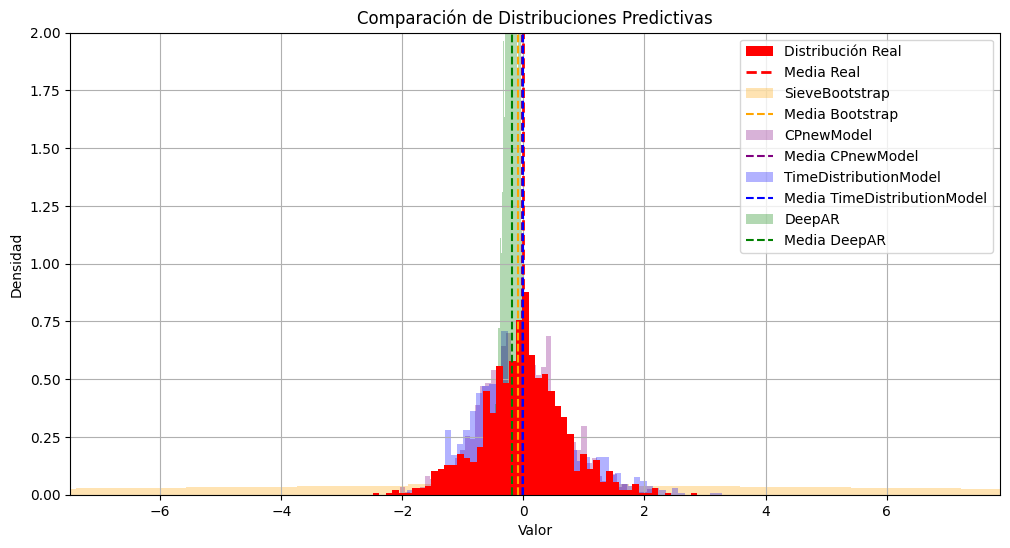

,Modelo,CRPS
3,DeepAR,0.061593
1,CPnewModel,0.162172
2,TimeDistributionModel,0.182877
0,SieveBootstrap,2.582223



=== Ejecutando escenario: Volatilidad moderada ===


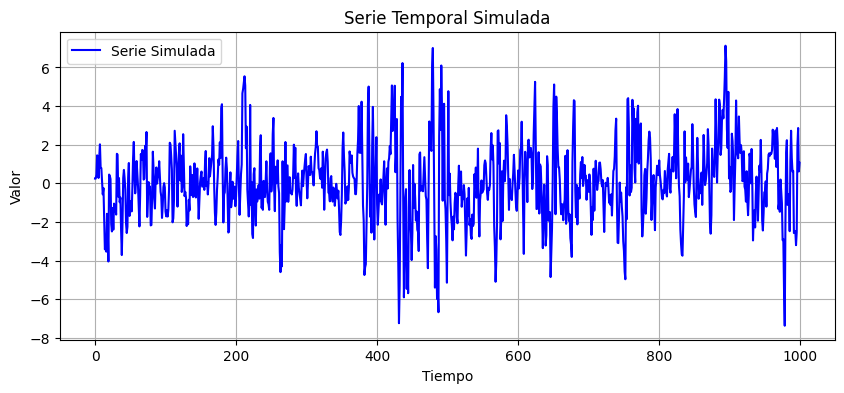

Bootstrapping: Mejor n_lags encontrado: 9, CRPS = 3.5360
✓ TimeDistributionModel - Mejores parámetros: n_lags = 7, rho = 0.990, CRPS = 0.4813
Epoch [20/100], Loss: -0.0209
Epoch [40/100], Loss: -0.0322
Epoch [60/100], Loss: -0.0883
Epoch [80/100], Loss: -0.0483
Epoch [100/100], Loss: 0.5702


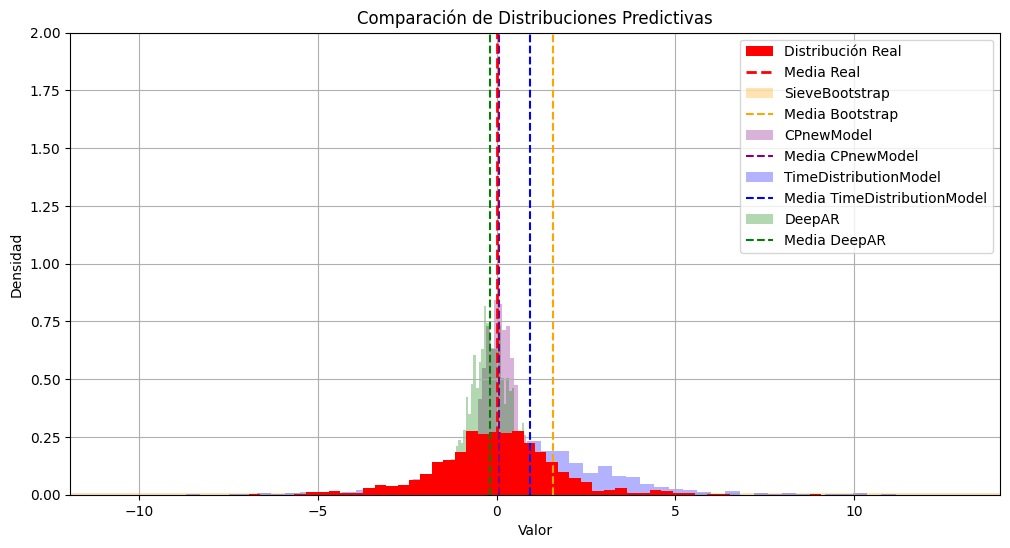

,Modelo,CRPS
2,TimeDistributionModel,0.481344
1,CPnewModel,0.719204
3,DeepAR,0.925849
0,SieveBootstrap,17.128602



=== Ejecutando escenario: Volatilidad intensa ===


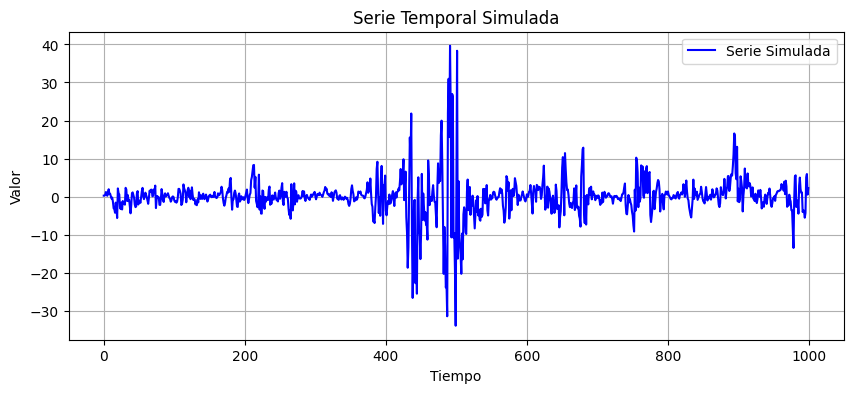

Bootstrapping: Mejor n_lags encontrado: 9, CRPS = 3.6303
✓ TimeDistributionModel - Mejores parámetros: n_lags = 6, rho = 0.990, CRPS = 0.6763
Epoch [20/100], Loss: -0.5676
Epoch [40/100], Loss: 0.0291
Epoch [60/100], Loss: -0.8657
Epoch [80/100], Loss: -0.2588
Epoch [100/100], Loss: 0.2769


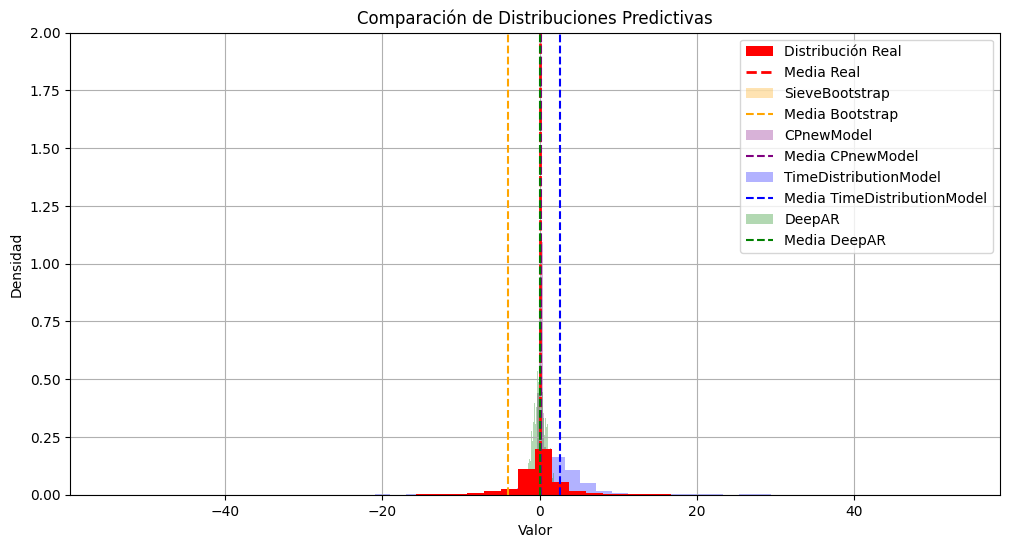

,Modelo,CRPS
2,TimeDistributionModel,0.676308
3,DeepAR,1.723504
1,CPnewModel,1.840096
0,SieveBootstrap,136.322567



=== Ejecutando escenario: Memoria larga persistente ===


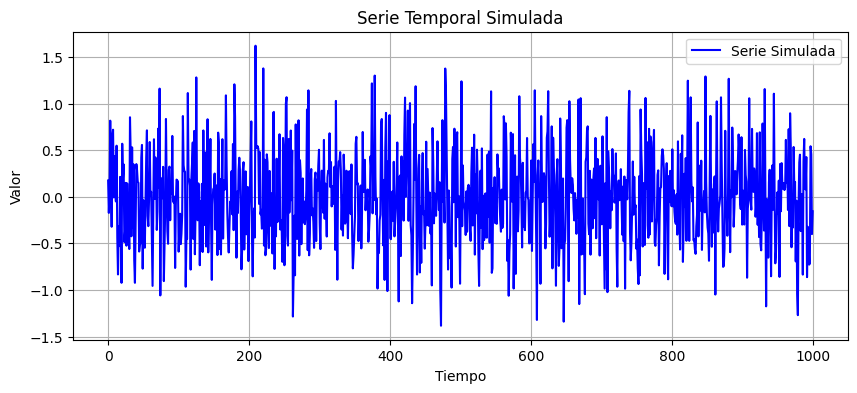

Bootstrapping: Mejor n_lags encontrado: 9, CRPS = 4.7026
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.500, CRPS = 0.1075
Epoch [20/100], Loss: -0.0400
Epoch [40/100], Loss: 0.4845
Epoch [60/100], Loss: 0.6233
Epoch [80/100], Loss: -0.6370
Epoch [100/100], Loss: 0.1715


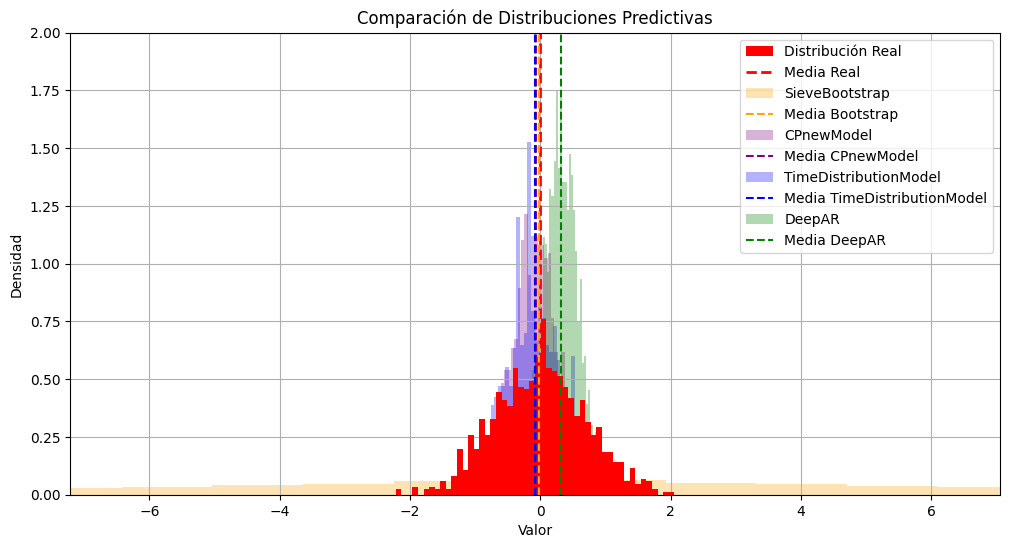

,Modelo,CRPS
1,CPnewModel,0.090507
2,TimeDistributionModel,0.107476
3,DeepAR,0.334576
0,SieveBootstrap,1.777261



=== Ejecutando escenario: Memoria larga anti-persistente ===


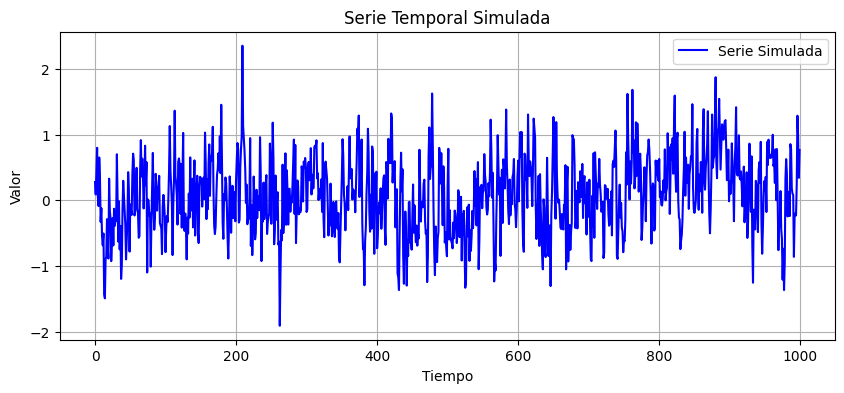

Bootstrapping: Mejor n_lags encontrado: 1, CRPS = 4.1256
✓ TimeDistributionModel - Mejores parámetros: n_lags = 6, rho = 0.990, CRPS = 0.1375
Epoch [20/100], Loss: 0.4539
Epoch [40/100], Loss: -0.0767
Epoch [60/100], Loss: -0.0317
Epoch [80/100], Loss: 0.2573
Epoch [100/100], Loss: 0.6694


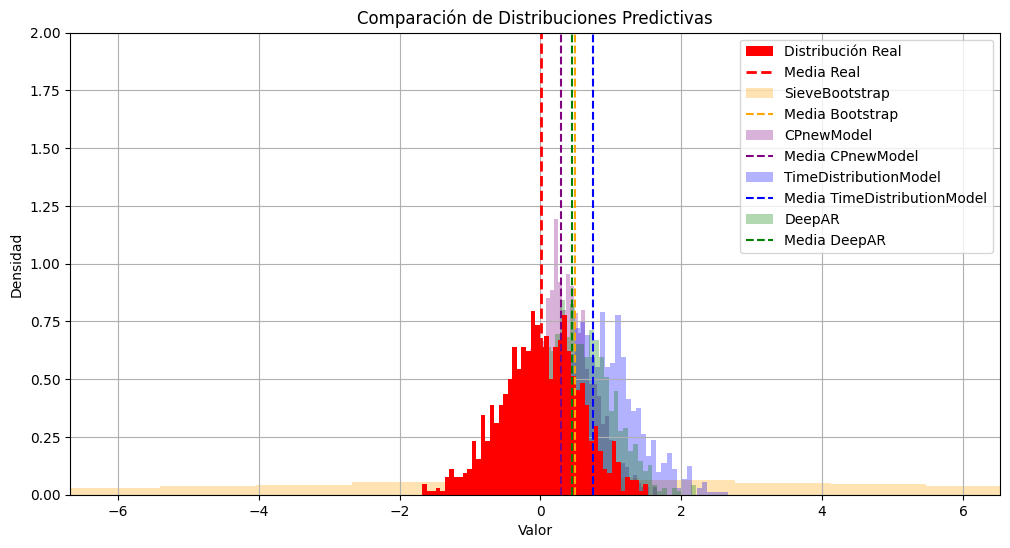

,Modelo,CRPS
2,TimeDistributionModel,0.137453
3,DeepAR,0.198046
1,CPnewModel,0.293926
0,SieveBootstrap,1.670637



=== Ejecutando escenario: Pocos outliers y datos faltantes ===


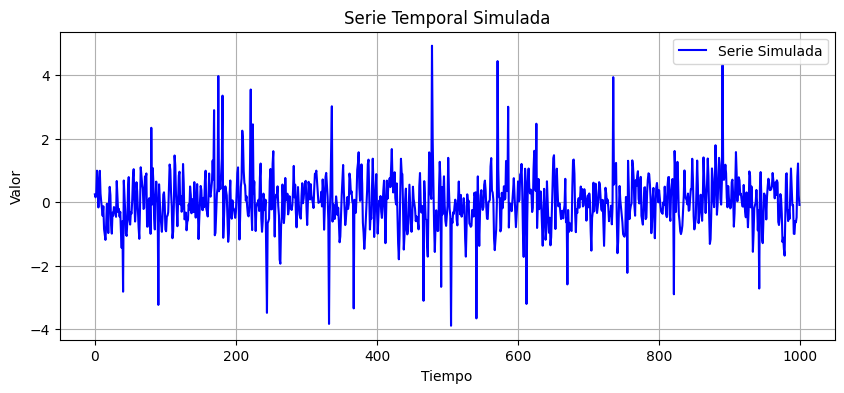

Bootstrapping: Mejor n_lags encontrado: 8, CRPS = 4.2242
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.500, CRPS = 0.1647
Epoch [20/100], Loss: -0.1005
Epoch [40/100], Loss: -0.2712
Epoch [60/100], Loss: 0.3173
Epoch [80/100], Loss: -0.2529
Epoch [100/100], Loss: 0.1209


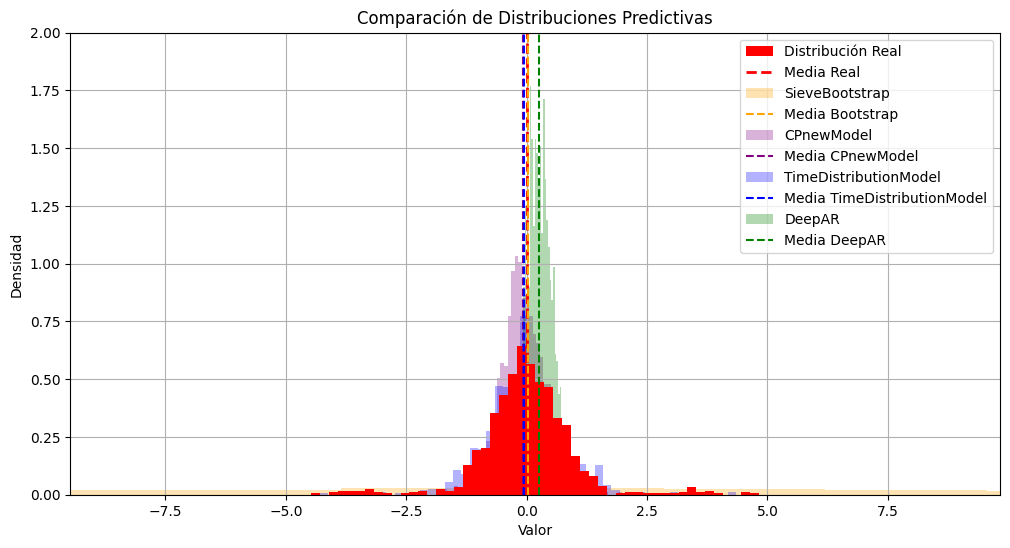

,Modelo,CRPS
1,CPnewModel,0.100533
2,TimeDistributionModel,0.164696
3,DeepAR,0.212396
0,SieveBootstrap,4.123010



=== Ejecutando escenario: Muchos outliers y datos faltantes ===


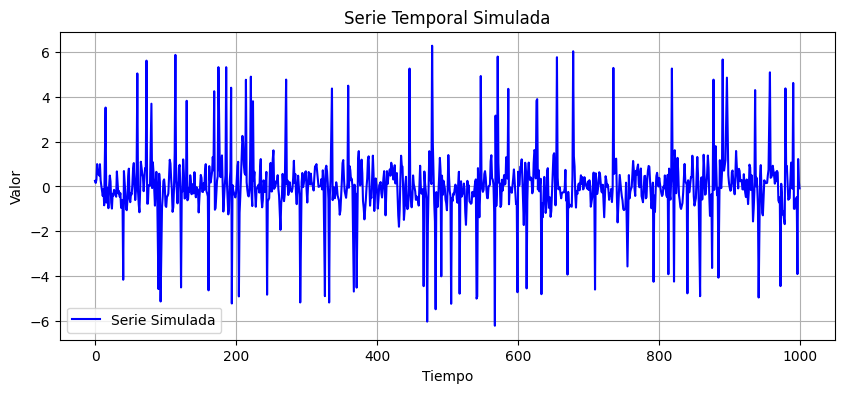

Bootstrapping: Mejor n_lags encontrado: 9, CRPS = 4.3969
✓ TimeDistributionModel - Mejores parámetros: n_lags = 1, rho = 0.500, CRPS = 0.2067
Epoch [20/100], Loss: -0.1646
Epoch [40/100], Loss: -0.3489
Epoch [60/100], Loss: -0.3101
Epoch [80/100], Loss: -1.0737
Epoch [100/100], Loss: 1.3840


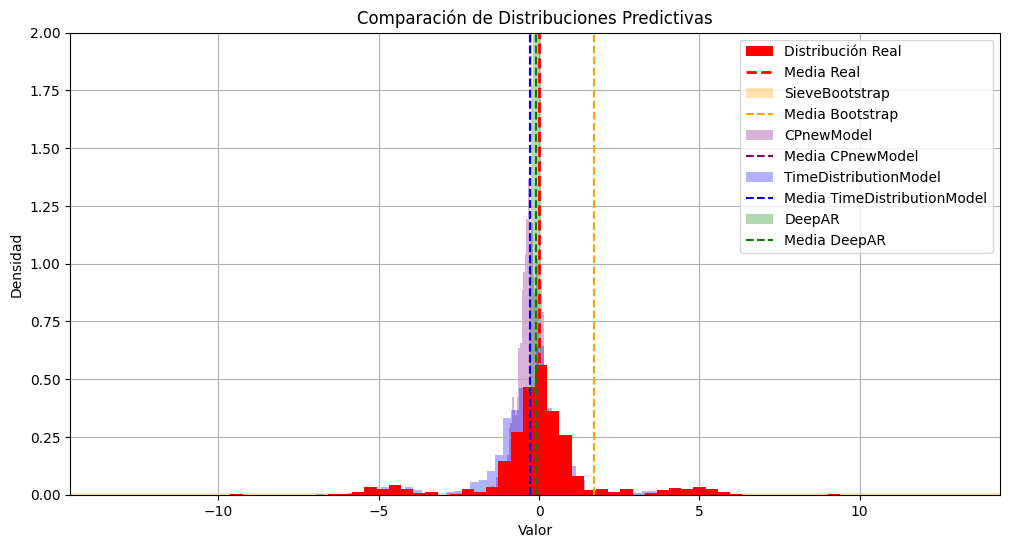

,Modelo,CRPS
3,DeepAR,0.022995
1,CPnewModel,0.126391
2,TimeDistributionModel,0.206679
0,SieveBootstrap,13.464591



=== RESUMEN DE RESULTADOS ===
+--------------------------------------------+------------------+-------------------+----------------------+---------------+-----------------------+
| Escenario                                  |   CRPS Bootstrap |   CRPS CPnewModel |   CRPS TimeDistModel |   CRPS DeepAR | Mejor Modelo          |
+============================================+==================+===================+======================+===============+=======================+
| Ruido normal                               |           2.8415 |            0.6147 |               0.2431 |        0.2658 | TimeDistributionModel |
+--------------------------------------------+------------------+-------------------+----------------------+---------------+-----------------------+
| Ruido uniform                              |           2.5911 |            0.1764 |               0.1908 |        0.7707 | CPnewModel            |
+--------------------------------------------+------------------+----------

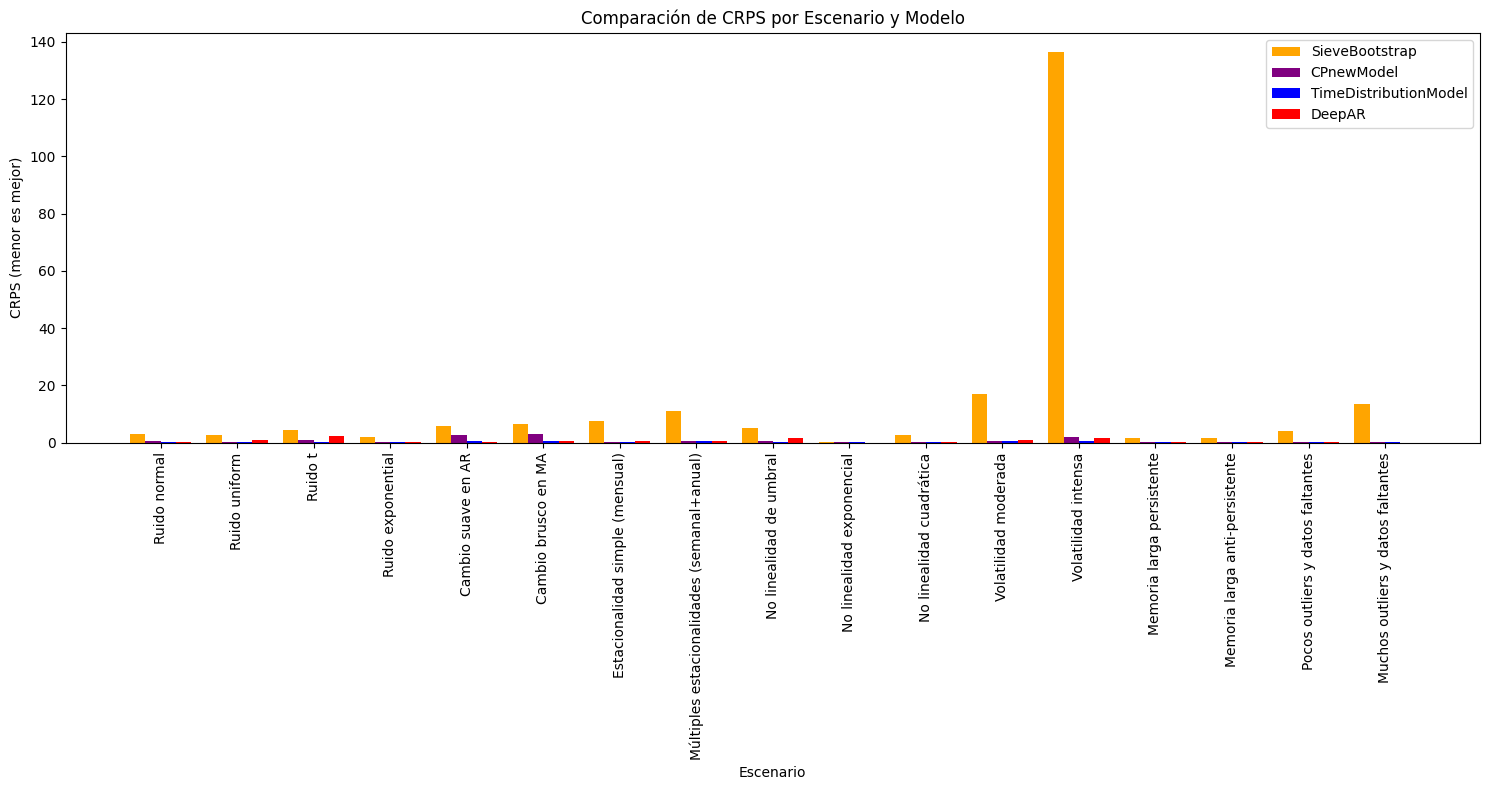

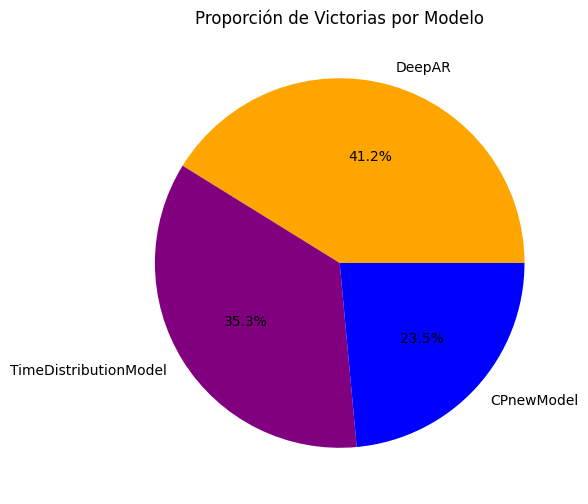

In [13]:
import numpy as np
import pandas as pd
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess

class TimeSeriesScenarios:
    """Generador de escenarios diversos para probar modelos de series temporales"""
    
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(seed)
        
    def scenario_1_changing_noise_distribution(self):
        """Escenario 1: Cambios en la distribución del ruido"""
        scenarios = []
        distributions = ['normal', 'uniform', 't', 'exponential']
        
        for dist in distributions:
            scenario = {
                'name': f"Ruido {dist}",
                'phi': [0.5, -0.36],
                'theta': [0.4],
                'noise_dist': dist,
                'sigma': 0.5,
                'n': 1000,
                'burn_in': 100,
                'bootstrap_reps': 500
            }
            scenarios.append(scenario)
            
        return scenarios
    
    def scenario_2_structural_breaks(self):
        """Escenario 2: Series con cambios estructurales"""
        class StructuralBreakSimulator:
            def __init__(self, phi1, phi2, theta1, theta2, break_point, n, burn_in, noise_dist='normal', sigma=0.5):
                self.phi1 = phi1
                self.phi2 = phi2
                self.theta1 = theta1
                self.theta2 = theta2
                self.break_point = break_point
                self.n = n
                self.burn_in = burn_in
                self.noise_dist = noise_dist
                self.sigma = sigma
                
            def generate_noise(self):
                if self.noise_dist == 'normal':
                    return np.random.normal(0, self.sigma, self.n)
                else:
                    raise ValueError("Solo se soporta ruido normal para este escenario")
                
            def simulate_with_break(self):
                noise = self.generate_noise()
                
                # Primera parte de la serie
                arma1 = ArmaProcess(ar=np.r_[1, -np.array(self.phi1)], ma=np.r_[1, self.theta1])
                series1 = arma1.generate_sample(nsample=self.break_point)
                
                # Segunda parte de la serie
                arma2 = ArmaProcess(ar=np.r_[1, -np.array(self.phi2)], ma=np.r_[1, self.theta2])
                series2 = arma2.generate_sample(nsample=self.n-self.break_point)
                
                # Combinar ambas partes
                full_series = np.concatenate([series1, series2])
                
                return full_series[self.burn_in:], noise[self.burn_in:]
        
        scenarios = []
        
        # Escenario con cambio suave en AR
        scenario_1 = {
            'name': "Cambio suave en AR",
            'simulator': StructuralBreakSimulator(
                phi1=[0.3, -0.2],
                phi2=[0.7, -0.4],
                theta1=[0.2],
                theta2=[0.3],
                break_point=500,
                n=1000,
                burn_in=100
            ),
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Escenario con cambio brusco en MA
        scenario_2 = {
            'name': "Cambio brusco en MA",
            'simulator': StructuralBreakSimulator(
                phi1=[0.5, -0.3],
                phi2=[0.5, -0.3],
                theta1=[0.2],
                theta2=[0.8],
                break_point=500,
                n=1000,
                burn_in=100
            ),
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_3_seasonality_patterns(self):
        """Escenario 3: Diferentes patrones de estacionalidad"""
        
        def generate_seasonal_series(n, seasonal_periods, amplitudes, phi, theta, sigma=0.5):
            # Generar componente ARMA
            arma = ArmaProcess(ar=np.r_[1, -np.array(phi)], ma=np.r_[1, theta])
            arma_component = arma.generate_sample(nsample=n, scale=sigma)
            
            # Generar componentes estacionales
            t = np.arange(n)
            seasonal_component = np.zeros(n)
            for period, amplitude in zip(seasonal_periods, amplitudes):
                seasonal_component += amplitude * np.sin(2 * np.pi * t / period)
                
            # Combinar componentes
            series = arma_component + seasonal_component
            return series
        
        scenarios = []
        
        # Serie con estacionalidad simple (periodo=12, como datos mensuales)
        scenario_1 = {
            'name': "Estacionalidad simple (mensual)",
            'generate_func': lambda: generate_seasonal_series(
                n=1000, 
                seasonal_periods=[12], 
                amplitudes=[2.0], 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,  # Ya no necesitamos burn-in aquí
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con múltiples estacionalidades (diaria=7, anual=365)
        scenario_2 = {
            'name': "Múltiples estacionalidades (semanal+anual)",
            'generate_func': lambda: generate_seasonal_series(
                n=1000, 
                seasonal_periods=[7, 365], 
                amplitudes=[1.0, 3.0], 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_4_nonlinear_patterns(self):
        """Escenario 4: Patrones no lineales en series temporales"""
        
        def generate_nonlinear_series(n, nonlinearity_type, phi, theta, sigma=0.5):
            # Generar componente ARMA
            arma = ArmaProcess(ar=np.r_[1, -np.array(phi)], ma=np.r_[1, theta])
            arma_component = arma.generate_sample(nsample=n, scale=sigma)
            
            if nonlinearity_type == 'threshold':
                # Modelo de umbral: comportamiento diferente sobre/bajo un umbral
                threshold = 0
                series = np.zeros(n)
                for t in range(1, n):
                    if arma_component[t-1] > threshold:
                        series[t] = 0.7 * series[t-1] + arma_component[t]
                    else:
                        series[t] = -0.7 * series[t-1] + arma_component[t]
                        
            elif nonlinearity_type == 'exponential':
                # Transformación exponencial
                series = np.exp(arma_component / 3) - 1
                
            elif nonlinearity_type == 'squared':
                # Componente cuadrático
                series = arma_component + 0.3 * arma_component**2
                
            else:
                raise ValueError("Tipo de no linealidad no soportado")
                
            return series
        
        scenarios = []
        
        # Serie con no linealidad de umbral
        scenario_1 = {
            'name': "No linealidad de umbral",
            'generate_func': lambda: generate_nonlinear_series(
                n=1000, 
                nonlinearity_type='threshold', 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con no linealidad exponencial
        scenario_2 = {
            'name': "No linealidad exponencial",
            'generate_func': lambda: generate_nonlinear_series(
                n=1000, 
                nonlinearity_type='exponential', 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        # Serie con no linealidad cuadrática
        scenario_3 = {
            'name': "No linealidad cuadrática",
            'generate_func': lambda: generate_nonlinear_series(
                n=1000, 
                nonlinearity_type='squared', 
                phi=[0.5, -0.3], 
                theta=[0.4]
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_3)
        
        return scenarios
    
    def scenario_5_volatility_clusters(self):
        """Escenario 5: Series con clusters de volatilidad (tipo GARCH)"""
        
        def generate_garch_like_series(n, phi, theta, a0=0.1, a1=0.2, b1=0.7, sigma=0.5):
            # Inicializar series
            series = np.zeros(n)
            volatility = np.zeros(n)
            errors = np.random.normal(0, 1, n)
            
            # Valores iniciales
            volatility[0] = sigma
            series[0] = sigma * errors[0]
            
            # Generar serie con volatilidad variable
            for t in range(1, n):
                # Actualizar volatilidad (proceso tipo GARCH)
                volatility[t] = np.sqrt(a0 + a1 * series[t-1]**2 + b1 * volatility[t-1]**2)
                
                # Generar valor de la serie
                series[t] = phi[0] * series[t-1] + theta[0] * errors[t-1] + volatility[t] * errors[t]
                
            return series
        
        scenarios = []
        
        # Serie con clusters de volatilidad moderados
        scenario_1 = {
            'name': "Volatilidad moderada",
            'generate_func': lambda: generate_garch_like_series(
                n=1000, 
                phi=[0.5], 
                theta=[0.4],
                a0=0.1,
                a1=0.1,
                b1=0.8
            ),
            'phi': [0.5],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con clusters de volatilidad intensos
        scenario_2 = {
            'name': "Volatilidad intensa",
            'generate_func': lambda: generate_garch_like_series(
                n=1000, 
                phi=[0.5], 
                theta=[0.4],
                a0=0.05,
                a1=0.3,
                b1=0.65
            ),
            'phi': [0.5],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_6_long_memory_processes(self):
        """Escenario 6: Procesos con memoria larga (tipo ARFIMA)"""
        
        def generate_long_memory_series(n, d, phi, theta, sigma=0.5):
            from statsmodels.tsa.arima_process import arma_generate_sample
            
            # Coeficientes de expansión para (1-L)^d
            k = 500  # número de coeficientes a usar en la aproximación
            j = np.arange(k)
            arfima_coef = np.array([1])
            for i in range(1, k):
                coef = arfima_coef[-1] * (i - 1 - d) / i
                arfima_coef = np.append(arfima_coef, coef)
                
            # Simular proceso ARMA
            arma_process = arma_generate_sample(ar=np.r_[1, -np.array(phi)], 
                                               ma=np.r_[1, np.array(theta)],
                                               nsample=n+k, scale=sigma)
            
            # Aplicar el filtro de memoria larga
            long_memory_series = np.zeros(n)
            for t in range(n):
                long_memory_series[t] = np.sum(arfima_coef * arma_process[t:t+k])
                
            return long_memory_series
        
        scenarios = []
        
        # Serie con memoria larga persistente (d > 0)
        scenario_1 = {
            'name': "Memoria larga persistente",
            'generate_func': lambda: generate_long_memory_series(
                n=1000, 
                d=0.3,  # 0 < d < 0.5 para proceso estacionario con memoria larga
                phi=[0.2], 
                theta=[0.1]
            ),
            'phi': [0.2],
            'theta': [0.1],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con memoria larga anti-persistente (d < 0)
        scenario_2 = {
            'name': "Memoria larga anti-persistente",
            'generate_func': lambda: generate_long_memory_series(
                n=1000, 
                d=-0.2,  # -0.5 < d < 0 para proceso anti-persistente
                phi=[0.2], 
                theta=[0.1]
            ),
            'phi': [0.2],
            'theta': [0.1],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def scenario_7_outliers_and_missing_data(self):
        """Escenario 7: Series con valores atípicos y datos faltantes"""
        
        def add_outliers_and_missing(series, outlier_prop=0.05, missing_prop=0.05, outlier_scale=5):
            modified_series = series.copy()
            n = len(series)
            
            # Agregar outliers
            outlier_indices = np.random.choice(n, size=int(n * outlier_prop), replace=False)
            outlier_signs = np.random.choice([-1, 1], size=len(outlier_indices))
            modified_series[outlier_indices] += outlier_signs * outlier_scale * np.std(series)
            
            # Agregar valores faltantes (NaN)
            missing_indices = np.random.choice(n, size=int(n * missing_prop), replace=False)
            modified_series[missing_indices] = np.nan
            
            return modified_series
        
        scenarios = []
        
        # Generar serie base ARMA
        def generate_base_series():
            arma = ArmaProcess(ar=np.r_[1, -0.5, 0.3], ma=np.r_[1, 0.4])
            return arma.generate_sample(nsample=1000, scale=0.5)
        
        # Serie con pocos outliers y datos faltantes
        scenario_1 = {
            'name': "Pocos outliers y datos faltantes",
            'generate_func': lambda: add_outliers_and_missing(
                generate_base_series(),
                outlier_prop=0.03,
                missing_prop=0.03
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_1)
        
        # Serie con muchos outliers y datos faltantes
        scenario_2 = {
            'name': "Muchos outliers y datos faltantes",
            'generate_func': lambda: add_outliers_and_missing(
                generate_base_series(),
                outlier_prop=0.08,
                missing_prop=0.08,
                outlier_scale=7
            ),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0,
            'bootstrap_reps': 500
        }
        scenarios.append(scenario_2)
        
        return scenarios
    
    def get_all_scenarios(self):
        """Recopila todos los escenarios disponibles"""
        all_scenarios = []
        
        # Escenario 1: Cambios en la distribución del ruido
        all_scenarios.extend(self.scenario_1_changing_noise_distribution())
        
        # Escenario 2: Series con cambios estructurales
        all_scenarios.extend(self.scenario_2_structural_breaks())
        
        # Escenario 3: Diferentes patrones de estacionalidad
        all_scenarios.extend(self.scenario_3_seasonality_patterns())
        
        # Escenario 4: Patrones no lineales
        all_scenarios.extend(self.scenario_4_nonlinear_patterns())
        
        # Escenario 5: Clusters de volatilidad
        all_scenarios.extend(self.scenario_5_volatility_clusters())
        
        # Escenario 6: Procesos con memoria larga
        all_scenarios.extend(self.scenario_6_long_memory_processes())
        
        # Escenario 7: Outliers y datos faltantes
        all_scenarios.extend(self.scenario_7_outliers_and_missing_data())
        
        return all_scenarios
    

# Asumiendo que ya tienes importadas todas las clases necesarias de tu código original
class EnhancedTimeSeriesPipeline:
    def __init__(self):
        self.results = []

    def run_scenario(self, scenario):
        """Ejecuta un escenario específico y evalúa los modelos"""
        print(f"\n=== Ejecutando escenario: {scenario['name']} ===")

        # Inicializar modelos
        bootstrap_model = SieveBootstrapModel(scenario['bootstrap_reps'])
        cp_model = CPnewModel()
        tdm_model = TimeDistributionModel()
        deepar_model = DeepARModel()
        plotter = PlotManager()

        # Generar o simular la serie según el tipo de escenario
        if 'simulator' in scenario:
            # Escenario con simulador personalizado (ej: cambios estructurales)
            series, clean_noise = scenario['simulator'].simulate_with_break()
        elif 'generate_func' in scenario:
            # Escenario con función generadora personalizada
            series = scenario['generate_func']()

            # Si hay NaN en la serie (escenario con datos faltantes)
            if np.isnan(series).any():
                # Interpolación simple para datos faltantes
                series_df = pd.Series(series)
                series = series_df.interpolate(method='linear').fillna(
                    method='bfill').fillna(method='ffill').values

                # Para el ruido, usamos una aproximación simple
                clean_noise = np.diff(series, prepend=series[0])
            else:
                # Para otros escenarios, aproximamos el ruido como la diferencia
                clean_noise = np.diff(series, prepend=series[0])
        else:
            # Escenario estándar con TimeSeriesSimulator
            simulator = TimeSeriesSimulator(
                phi=scenario['phi'],
                theta=scenario['theta'],
                noise_dist=scenario['noise_dist'],
                sigma=scenario.get('sigma', 0.5),
                n=scenario['n'],
                burn_in=scenario['burn_in']
            )
            noise = simulator.generate_noise()
            series, clean_noise = simulator.simulate_arma(noise)

        # Graficar la serie
        plotter.plot_series(series)

        # Crear DataFrame para los modelos
        df = pd.DataFrame({'valor': series})

        # Modelo SieveBootstrap

        bootstrap_samples = bootstrap_model.perform_bootstrap(series, clean_noise)
        crps_bootstrap = bootstrap_model.calculate_crps(clean_noise, bootstrap_samples)

        # Preparar valor real para evaluación
        y_real = series[-1]

        # Modelo CPnewModel
        try:
            cp_predictions = cp_model.fit_predict(df)
            crps_cp = cp_model.calculate_crps(cp_predictions, y_real)
        except Exception as e:
            print(f"Error en CPnewModel: {str(e)}")
            cp_predictions = None
            crps_cp = float('inf')

        # Modelo TimeDistributionModel
        try:
            try:
                tdm_model.grid_search(df)
            except:
                tdm_model.n_lags = 5
                tdm_model.rho = 0.95

            tdm_predictions = tdm_model.fit_predict(df)
            crps_tdm = tdm_model.calculate_crps(tdm_predictions, y_real)
        except Exception as e:
            print(f"Error en TimeDistributionModel: {str(e)}")
            tdm_predictions = None
            crps_tdm = float('inf')

        # Modelo DeepAR
        try:
            deepar_predictions = deepar_model.fit_predict(df)
            crps_deepar = deepar_model.calculate_crps(deepar_predictions, y_real)
        except Exception as e:
            print(f"Error en DeepAR: {str(e)}")
            deepar_predictions = None
            crps_deepar = float('inf')

        # Si hay predicciones válidas, graficamos la comparación
        if cp_predictions is not None and tdm_predictions is not None:
            plotter.plot_all_distributions(clean_noise, bootstrap_samples,
                                        cp_predictions, tdm_predictions, deepar_predictions)

        # Mostrar CRPS
        plotter.show_crps_results(crps_bootstrap, crps_cp, crps_tdm, crps_deepar)

        # Guardar resultados
        result = {
            'scenario': scenario['name'],
            'crps_bootstrap': crps_bootstrap,
            'crps_cp': crps_cp,
            'crps_tdm': crps_tdm,
            'crps_deepar': crps_deepar,
            'best_model': self._get_best_model_name(crps_bootstrap, crps_cp, crps_tdm, crps_deepar)
        }
        self.results.append(result)

        return result

    def _get_best_model_name(self, crps_bootstrap, crps_cp, crps_tdm, crps_deepar):
        """Determina cuál es el mejor modelo basado en CRPS"""
        crps_values = {
            'SieveBootstrap': crps_bootstrap,
            'CPnewModel': crps_cp,
            'TimeDistributionModel': crps_tdm,
        }
        # Agregar DeepAR solo si tiene un valor válido
        if crps_deepar != float('inf'):
            crps_values['DeepAR'] = crps_deepar

        return min(crps_values, key=crps_values.get)

    def run_all_scenarios(self, scenarios):
        """Ejecuta todos los escenarios y genera un informe"""
        for scenario in scenarios:
            self.run_scenario(scenario)

        self._show_summary_report()

    def _show_summary_report(self):
        """Muestra un informe resumen de todos los escenarios ejecutados"""
        # Convertir resultados a DataFrame
        results_df = pd.DataFrame(self.results)

        # Contar cuántas veces ganó cada modelo
        model_wins = results_df['best_model'].value_counts()

        print("\n=== RESUMEN DE RESULTADOS ===")

        # Mostrar tabla de resultados
        headers = ["Escenario", "CRPS Bootstrap", "CRPS CPnewModel", "CRPS TimeDistModel", "CRPS DeepAR", "Mejor Modelo"] # Agregar DeepAR a los headers
        table_data = []

        for _, row in results_df.iterrows():
            table_data.append([
                row['scenario'],
                f"{row['crps_bootstrap']:.4f}",
                f"{row['crps_cp']:.4f}" if row['crps_cp'] != float('inf') else "Error",
                f"{row['crps_tdm']:.4f}" if row['crps_tdm'] != float('inf') else "Error",
                f"{row['crps_deepar']:.4f}" if row['crps_deepar'] != float('inf') else "Error", # Imprimir CRPS de DeepAR
                row['best_model']
            ])

        print(tabulate(table_data, headers=headers, tablefmt="grid"))

        # Mostrar conteo de victorias
        print("\n=== VICTORIAS POR MODELO ===")
        for model, wins in model_wins.items():
            print(f"{model}: {wins} victoria(s)")

        # Calcular y mostrar CRPS promedio para cada modelo
        avg_bootstrap = results_df['crps_bootstrap'].mean()

        # Filtrar infinitos para calcular promedios
        cp_values = results_df['crps_cp'][results_df['crps_cp'] != float('inf')]
        tdm_values = results_df['crps_tdm'][results_df['crps_tdm'] != float('inf')]
        deepar_values = results_df['crps_deepar'][results_df['crps_deepar'] != float('inf')] # Filtrar infinitos para DeepAR

        avg_cp = cp_values.mean() if len(cp_values) > 0 else "N/A"
        avg_tdm = tdm_values.mean() if len(tdm_values) > 0 else "N/A"
        avg_deepar = deepar_values.mean() if len(deepar_values) > 0 else "N/A" # Calcular promedio de DeepAR

        print("\n=== CRPS PROMEDIO ===")
        print(f"SieveBootstrap: {avg_bootstrap:.4f}")
        print(f"CPnewModel: {avg_cp:.4f}" if isinstance(avg_cp, float) else f"CPnewModel: {avg_cp}")
        print(f"TimeDistributionModel: {avg_tdm:.4f}" if isinstance(avg_tdm, float) else f"TimeDistributionModel: {avg_tdm}")
        print(f"DeepAR: {avg_deepar:.4f}" if isinstance(avg_deepar, float) else f"DeepAR: {avg_deepar}") # Imprimir promedio de DeepAR

        # Graficar comparación de modelos
        self._plot_model_comparison()

    def _plot_model_comparison(self):
        """Genera gráficos comparativos de los modelos en todos los escenarios"""
        results_df = pd.DataFrame(self.results)

        # Reemplazar infinitos con NaN para no afectar la visualización
        results_df = results_df.replace([float('inf'), -float('inf')], np.nan)

        plt.figure(figsize=(15, 8))

        # Gráfico de barras para CRPS por escenario
        scenarios = results_df['scenario'].values
        x = np.arange(len(scenarios))
        width = 0.2

        bootstrap_values = results_df['crps_bootstrap'].values
        cp_values = results_df['crps_cp'].values
        tdm_values = results_df['crps_tdm'].values
        deepar_values = results_df['crps_deepar'].values

        plt.bar(x - 1.5*width, bootstrap_values, width, label='SieveBootstrap', color='orange')
        plt.bar(x - 0.5*width, cp_values, width, label='CPnewModel', color='purple')
        plt.bar(x + 0.5*width, tdm_values, width, label='TimeDistributionModel', color='blue')
        plt.bar(x + 1.5*width, deepar_values, width, label='DeepAR', color='red')

        plt.xlabel('Escenario')
        plt.ylabel('CRPS (menor es mejor)')
        plt.title('Comparación de CRPS por Escenario y Modelo')
        plt.xticks(x, scenarios, rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Gráfico de pastel para victorias
        plt.figure(figsize=(10, 6))
        model_wins = results_df['best_model'].value_counts()
        plt.pie(model_wins, labels=model_wins.index, autopct='%1.1f%%',
                colors=['orange', 'purple', 'blue', 'red']) # Agregar color para DeepAR
        plt.title('Proporción de Victorias por Modelo')
        plt.show()

# Código para ejecutar todos los escenarios
if __name__ == "__main__":
    # Crear generador de escenarios
    scenario_generator = TimeSeriesScenarios()
    all_scenarios = scenario_generator.get_all_scenarios()

    # Crear y ejecutar el pipeline mejorado
    enhanced_pipeline = EnhancedTimeSeriesPipeline()
    enhanced_pipeline.run_all_scenarios(all_scenarios)